In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import pyplot
from matplotlib import dates as mpl_dates
import matplotlib.font_manager as fm
%matplotlib inline

import seaborn as sns
from scipy import stats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Linear Regression 그리기
from sklearn.linear_model import LinearRegression

# Counter 모듈
from collections import Counter
from operator import itemgetter

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

#  ① DATA-LIST 불러오기 (구간별 Time 이용)

In [2]:
df = pd.read_csv('BATT_LOW_S1_SOC.csv', sep='\t', encoding='UTF-8')
df.head(3)

Plant Name Project CD Body CD  Body No.  Device Type  Inspec. Item(Plant)  \
0        소하1         CK      J5     81866  F-SCAN  VOL       배터리 전압_람다 3.3T   
1        소하1         CK      J5     81866  F-SCAN  SOC  배터리 SOC_람다 3.3T_ISG   
2        소하1         CK      J5     81866  F-SCAN  SOH  배터리_노화율_람다 3.3T_ISG   

  Inspec. Date Inspec. Time  Value  
0   2020-02-04   PM 5:37:55   12.3  
1   2020-02-04   PM 5:37:55   97.0  
2   2020-02-04   PM 5:37:55   97.0

In [3]:
# 컬럼 Rename
df.columns = ['Plant','Project','Body','Body_No','Device','Type','Inspec_Item','Inspec_Date','Inspec_Time','Value']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27978 entries, 0 to 27977
Data columns (total 10 columns):
Plant          27978 non-null object
Project        27978 non-null object
Body           27978 non-null object
Body_No        27978 non-null int64
Device         27978 non-null object
Type           27978 non-null object
Inspec_Item    27978 non-null object
Inspec_Date    27978 non-null object
Inspec_Time    27978 non-null object
Value          27978 non-null float64
dtypes: float64(1), int64(1), object(8)
memory usage: 2.1+ MB


### [전처리] Datetime 00:00:00 ~ 24:00:00로 변경

In [5]:
df.head(3)

Plant Project Body  Body_No  Device Type          Inspec_Item Inspec_Date  \
0   소하1      CK   J5    81866  F-SCAN  VOL       배터리 전압_람다 3.3T  2020-02-04   
1   소하1      CK   J5    81866  F-SCAN  SOC  배터리 SOC_람다 3.3T_ISG  2020-02-04   
2   소하1      CK   J5    81866  F-SCAN  SOH  배터리_노화율_람다 3.3T_ISG  2020-02-04   

  Inspec_Time  Value  
0  PM 5:37:55   12.3  
1  PM 5:37:55   97.0  
2  PM 5:37:55   97.0

In [6]:
# Inspec_Date열을 시간속성으로 변경하기
df['Inspec_Date'] = pd.to_datetime(df['Inspec_Date'], format='%Y-%m-%d')  

# AM,PM타입을 24시간 속성으로 변경해주기
for i in range(len(df)):    
    if df.iloc[i,8][:2] == 'AM' and df.iloc[i,8][2:-6] == ' 12': # 빈 공백도 포함해야 함
        df.iloc[i,8] = '00' + df.iloc[i,8][-6:]
    elif df.iloc[i,8][:2] == 'AM':
        df.iloc[i,8] = df.iloc[i,8][2:]
    elif df.iloc[i,8][:2] == 'PM' and df.iloc[i,8][2:-6] == ' 12':
        df.iloc[i,8] = '12' + df.iloc[i,8][-6:]
    elif df.iloc[i,8][:2] == 'PM':
        df.iloc[i,8] = str(int(df.iloc[i,8][2:-6]) + 12) + df.iloc[i,8][-6:]
#     else :
#         df.iloc[i,8] = df.iloc[i,8][2:]
        
# 24시 이상인 것은 날짜에 1을 더해주기
# for j in range(len(df)):
#     if df.iloc[j,8][:2] == '24':
#         df.iloc[j,7] = df.iloc[j,7] + timedelta(days=1)

# Inspec_Time열의 24시 → 00시로 변경하기
# df['Inspec_Time'] = df['Inspec_Time'].str.replace('24','00')  

# Inspec_Date열을 문자속성으로 원복하기        
for i in range(len(df)):
    df.loc[i,'Inspec_Date'] = df.loc[i,'Inspec_Date'].strftime('%Y-%m-%d')
    
# Inspec_Date열과 Inspec_Time열값을 합해서 Datetime 열에 넣어서 새로 생성하기
df['Datetime'] = df['Inspec_Date'] + ' ' + df['Inspec_Time'] 

# Datetime 열에서 시간이 10보다 작은 숫자가 1~9로 표현된 것을 01,02,...,08,09식으로 변경해주기
for i in range(len(df)):
    if int(df.iloc[i,10][11:-6]) > 0 and int(df.iloc[i,10][11:-6]) < 10:
        df.iloc[i,10] = df.iloc[i,10][:11] + '0' + df.iloc[i,10][-7:]

# Datetime 열을 시간속성으로 변경해주기
df['Datetime'] = pd.to_datetime(df['Datetime'],format='%Y-%m-%d  %H:%M:%S')

In [7]:
# pd.unique(df['Inspec_Time'])
# SOC - 숫자별 Counter
sorted(sorted(Counter (df['Inspec_Time']).items(), key=itemgetter(1), reverse = True))

[(' 10:00:01', 3),
 (' 10:00:05', 3),
 (' 10:00:06', 3),
 (' 10:00:10', 3),
 (' 10:00:13', 3),
 (' 10:00:16', 3),
 (' 10:00:24', 3),
 (' 10:00:28', 3),
 (' 10:00:33', 3),
 (' 10:00:41', 3),
 (' 10:00:42', 3),
 (' 10:00:45', 3),
 (' 10:00:49', 3),
 (' 10:00:50', 3),
 (' 10:00:54', 3),
 (' 10:00:55', 3),
 (' 10:01:01', 3),
 (' 10:01:05', 3),
 (' 10:01:07', 3),
 (' 10:01:17', 6),
 (' 10:01:34', 3),
 (' 10:01:36', 3),
 (' 10:01:41', 3),
 (' 10:01:45', 3),
 (' 10:01:46', 8),
 (' 10:01:47', 3),
 (' 10:01:51', 6),
 (' 10:01:52', 3),
 (' 10:01:54', 3),
 (' 10:01:57', 3),
 (' 10:01:59', 3),
 (' 10:02:15', 3),
 (' 10:02:18', 3),
 (' 10:02:20', 3),
 (' 10:02:23', 3),
 (' 10:02:27', 3),
 (' 10:02:28', 6),
 (' 10:02:38', 6),
 (' 10:02:42', 3),
 (' 10:02:43', 3),
 (' 10:02:46', 2),
 (' 10:02:52', 3),
 (' 10:03:01', 6),
 (' 10:03:06', 3),
 (' 10:03:07', 3),
 (' 10:03:08', 3),
 (' 10:03:09', 2),
 (' 10:03:10', 3),
 (' 10:03:11', 2),
 (' 10:03:13', 3),
 (' 10:03:18', 6),
 (' 10:03:20', 3),
 (' 10:03:34

# ② Vehicl-List 불러오기 (B/No 기준 측정값)

In [8]:
df2 = pd.read_csv('BATT_LOW(0201~0221).csv', sep='\t', encoding='UTF-8')
df2.head(3)

Plant Name Project CD Body CD  Body No.  VIN Writing  VIN Writing.1  \
0        소하1         CK      J5     81866          NaN            NaN   
1        소하1         CK      J5     82108          NaN            NaN   
2        소하1         CK      J5     82588          NaN            NaN   

   VIN Writing.2 Keycoding Keycoding.1 Keycoding.2  ... DTC Eraser(Final).2  \
0            NaN       NaN         NaN         NaN  ...                 NaN   
1            NaN       NaN         NaN         NaN  ...                  96   
2            NaN       NaN         NaN         NaN  ...                 100   

  F-SCAN F-SCAN.1 F-SCAN.2 (R)HADS (R)HADS.1 (R)HADS.2 (R)F-SCAN  (R)F-SCAN.1  \
0   12.3       97     97.0    14.4        95        95       NaN          NaN   
1    NaN      NaN      NaN    14.3        96        96       NaN          NaN   
2   11.9       71    100.0     NaN       NaN       NaN       NaN          NaN   

  (R)F-SCAN.2  
0         NaN  
1         NaN  
2         NaN  

[3 rows x 25 columns]

In [9]:
# 컬럼 Rename
df2.columns = ['Plant','Project','Body','Body_No','VIN-VOL','VIN-SOC','VIN-SOH','Key-VOL','Key-SOC','Key-SOH','HADS-VOL','HADS-SOC','HADS-SOH','DTC-VOL','DTC-SOC','DTC-SOH','FSCAN-VOL','FSCAN-SOC','FSCAN-SOH','(R)HADS-VOL','(R)HADS-SOC','(R)HADS-SOH','(R)FSCAN-VOL','(R)FSCAN-SOC','(R)FSCAN-SOH']
df2.head(2)

Plant Project Body  Body_No  VIN-VOL  VIN-SOC  VIN-SOH Key-VOL Key-SOC  \
0   소하1      CK   J5    81866      NaN      NaN      NaN     NaN     NaN   
1   소하1      CK   J5    82108      NaN      NaN      NaN     NaN     NaN   

  Key-SOH  ... DTC-SOH FSCAN-VOL FSCAN-SOC FSCAN-SOH (R)HADS-VOL (R)HADS-SOC  \
0     NaN  ...     NaN      12.3        97      97.0        14.4          95   
1     NaN  ...      96       NaN       NaN       NaN        14.3          96   

  (R)HADS-SOH (R)FSCAN-VOL  (R)FSCAN-SOC (R)FSCAN-SOH  
0          95          NaN           NaN          NaN  
1          96          NaN           NaN          NaN  

[2 rows x 25 columns]

### [전처리] SOC 이상값 수정 : 100 이상 → 100

In [10]:
# SOC 데이터 숫자 타입으로 변경
df2['VIN-SOC'] = pd.to_numeric(df2['VIN-SOC'],errors='coerce')
df2['Key-SOC'] = pd.to_numeric(df2['Key-SOC'],errors='coerce')
df2['HADS-SOC'] = pd.to_numeric(df2['HADS-SOC'],errors='coerce')
df2['DTC-SOC'] = pd.to_numeric(df2['DTC-SOC'],errors='coerce')
df2['FSCAN-SOC'] = pd.to_numeric(df2['FSCAN-SOC'],errors='coerce')
df2['(R)HADS-SOC'] = pd.to_numeric(df2['(R)HADS-SOC'],errors='coerce')
df2['(R)FSCAN-SOC'] = pd.to_numeric(df2['(R)FSCAN-SOC'],errors='coerce')
df2['VIN-SOH'] = pd.to_numeric(df2['VIN-SOH'],errors='coerce')
df2['Key-SOH'] = pd.to_numeric(df2['Key-SOH'],errors='coerce')
df2['HADS-SOH'] = pd.to_numeric(df2['HADS-SOH'],errors='coerce')
df2['DTC-SOH'] = pd.to_numeric(df2['DTC-SOH'],errors='coerce')
df2['FSCAN-SOH'] = pd.to_numeric(df2['FSCAN-SOH'],errors='coerce')
df2['(R)HADS-SOH'] = pd.to_numeric(df2['(R)HADS-SOH'],errors='coerce')
df2['(R)FSCAN-SOH'] = pd.to_numeric(df2['(R)FSCAN-SOH'],errors='coerce')

In [11]:
# 100이상 값은 100으로 강제 변경
for i in range(len(df2['Body'])):
    if df2['VIN-SOC'].loc[i] > 100 : df2['VIN-SOC'].loc[i] = 100
    if df2['Key-SOC'].loc[i] > 100 : df2['Key-SOC'].loc[i] = 100
    if df2['HADS-SOC'].loc[i] > 100 : df2['HADS-SOC'].loc[i] = 100
    if df2['DTC-SOC'].loc[i] > 100 : df2['DTC-SOC'].loc[i] = 100
    if df2['FSCAN-SOC'].loc[i] > 100 : df2['FSCAN-SOC'].loc[i] = 100
    if df2['(R)HADS-SOC'].loc[i] > 100 : df2['HADS-SOC'].loc[i] = 100
    if df2['(R)FSCAN-SOC'].loc[i] > 100 : df2['FSCAN-SOC'].loc[i] = 100

C:\Users\5608138\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
# 100 이상값 확인
print (pd.unique(df2['VIN-SOC']))
print (pd.unique(df2['Key-SOC']))
print (pd.unique(df2['HADS-SOC']))
print (pd.unique(df2['DTC-SOC']))
print (pd.unique(df2['FSCAN-SOC']))
print (pd.unique(df2['(R)HADS-SOC']))
print (pd.unique(df2['(R)FSCAN-SOC']))

[  nan  94.   42.   93.   91.   90.   92.   89.  100.   95.   93.8   0. ]
[ nan 81.  85.  84.  83.  82.  79.  86.  87.  29.  80.  88.  25.  35.
 36.  43.  42.  89.  33.  37.  76.  71.  75.  78.  95.  77.  90.  91.
 92.  93.  77.7 94.  48.  26.  49.   0.  99.  96.  98.  74. ]
[ nan 74.  70.  72.  76.  78.  84.  63.  82.  85.  83.  77.  86.  36.
 88.   3.  87.  90.  89.  32.  81.  80.  79.  41.  42.  91.  51.  26.
 44.  93.  75.  61.  96.  35.  92.  68.  14.  71.  69.  62.  79.7 78.9
 64.  67.  65.  95.  73.  98.  94.  97.  99.  31.  60.   0.  47.  49.
 66. ]
[ nan 96.  74.  81.  46.  93.   4.  89.  90.  94.  85.  86.  82.  95.
 91.  92.  84.  88.  87.  60.  78.  83.  77.  70.  76.  75.  79.  66.
 80.  73.  72.  38.  98.  21.  64.  55.  82.8 63.  70.7 80.9 67.  69.
 99.  68.  97.  44.  47.  41.  48.  52.  59.  54.  71.  49.  65.  58. ]
[97.   nan 71.  95.  82.  79.  87.  93.  74.  98.  90.  70.  84.  96.
 89.  99.  83.  91.  94.  92.  85.  86.  80.  75.  50.  78.  81.  36.
 76.  77.  72.

### Vehicle-List 각 구간별 Time 컬럼 생성 (Data-List Time 활용)

In [13]:
# 컬럼 추가 - "NaN" 값 입력
# df2['VIN-Time','Key-Time','HADS-Time','DTC-Time','FSCAN-Time','(R)HADS-Time','(R)FSCAN-Time'] = ["NaN","NaN","NaN","NaN","NaN","NaN"]
# np.nan

df2['VIN-Time'] = "NaN"
df2['Key-Time'] = "NaN"
df2['HADS-Time'] = "NaN"
df2['DTC-Time'] = "NaN"
df2['FSCAN-Time'] = "NaN"
df2['(R)HADS-Time'] = "NaN"
df2['(R)FSCAN-Time'] = "NaN"


# Create DataFrame 방법 - 공백 컬럼으로 생성
# df3 = pd.DataFrame(index=df2.index, columns=['VIN-Time','Key-Time','HADS-Time','DTC-Time','FSCAN-Time'])
# df3.head(2)

In [14]:
df2.head(3)

Plant Project Body  Body_No  VIN-VOL  VIN-SOC  VIN-SOH Key-VOL  Key-SOC  \
0   소하1      CK   J5    81866      NaN      NaN      NaN     NaN      NaN   
1   소하1      CK   J5    82108      NaN      NaN      NaN     NaN      NaN   
2   소하1      CK   J5    82588      NaN      NaN      NaN     NaN      NaN   

   Key-SOH  ... (R)FSCAN-VOL  (R)FSCAN-SOC  (R)FSCAN-SOH VIN-Time  Key-Time  \
0      NaN  ...          NaN           NaN           NaN      NaN       NaN   
1      NaN  ...          NaN           NaN           NaN      NaN       NaN   
2      NaN  ...          NaN           NaN           NaN      NaN       NaN   

   HADS-Time DTC-Time  FSCAN-Time  (R)HADS-Time (R)FSCAN-Time  
0        NaN      NaN         NaN           NaN           NaN  
1        NaN      NaN         NaN           NaN           NaN  
2        NaN      NaN         NaN           NaN           NaN  

[3 rows x 32 columns]

In [15]:
# 신규컬럼에 데이터 값 입력
for i in range(len(df2['Body_No'])) :
    for j in range(len(df['Body_No'])) :
        if j >= i*3 :
            if df2['Body_No'].loc[i] == df['Body_No'].loc[j] :
                if df['Device'].loc[j] == 'VIN Writing' :
                    if df['Type'].loc[j] == 'SOC' :
                        df2['VIN-Time'].loc[i] = df['Datetime'].loc[j]
                elif df['Device'].loc[j] == 'Keycoding' :
                    if df['Type'].loc[j] == 'SOC' :
                        df2['Key-Time'].loc[i] = df['Datetime'].loc[j]
                elif df['Device'].loc[j] == 'HADS' :
                    if df['Type'].loc[j] == 'SOC' :
                        df2['HADS-Time'].loc[i] = df['Datetime'].loc[j]
                elif df['Device'].loc[j] == 'DTC Eraser(Final)' :
                    if df['Type'].loc[j] == 'SOC' :
                        df2['DTC-Time'].loc[i] = df['Datetime'].loc[j]
                elif df['Device'].loc[j] == 'F-SCAN' :
                    if df['Type'].loc[j] == 'SOC' :
                        df2['FSCAN-Time'].loc[i] = df['Datetime'].loc[j]
                elif df['Device'].loc[j] == '(R)HADS' :
                    if df['Type'].loc[j] == 'SOC' :
                        df2['(R)HADS-Time'].loc[i] = df['Datetime'].loc[j]
                elif df['Device'].loc[j] == '(R)F-SCAN' :
                    if df['Type'].loc[j] == 'SOC' :
                        df2['(R)FSCAN-Time'].loc[i] = df['Datetime'].loc[j]

In [16]:
# 데이터 타입 변환
df2['VIN-Time'] = pd.to_datetime(df2['VIN-Time'],format='%Y-%m-%d  %H:%M:%S') 
df2['Key-Time'] = pd.to_datetime(df2['Key-Time'],format='%Y-%m-%d  %H:%M:%S') 
df2['HADS-Time'] = pd.to_datetime(df2['HADS-Time'],format='%Y-%m-%d  %H:%M:%S') 
df2['DTC-Time'] = pd.to_datetime(df2['DTC-Time'],format='%Y-%m-%d  %H:%M:%S') 
df2['FSCAN-Time'] = pd.to_datetime(df2['FSCAN-Time'],format='%Y-%m-%d  %H:%M:%S') 
df2['(R)HADS-Time'] = pd.to_datetime(df2['(R)HADS-Time'],format='%Y-%m-%d  %H:%M:%S')
df2['(R)FSCAN-Time'] = pd.to_datetime(df2['(R)FSCAN-Time'],format='%Y-%m-%d  %H:%M:%S') 

In [17]:
# 컬럼 추가
df2['Time(Key-VIN)'] = "NaN"
df2['Time(HADS-Key)'] = "NaN"
df2['Time(DTC-HADS)'] = "NaN"
df2['Time(FSCAN-DTC)'] = "NaN"
df2['SOC(Key-VIN)'] = "NaN"
df2['SOC(HADS-Key)'] = "NaN"
df2['SOC(DTC-HADS)'] = "NaN"
df2['SOC(FSCAN-DTC)'] = "NaN"

In [18]:
# 시간차 차이 컬럼에 데이터 추가 (데이터 값이 하나뿐인 것들은 차이값 제외)
df2['Time(Key-VIN)'] = df2['Key-Time'] - df2['VIN-Time']
df2['Time(HADS-Key)'] = df2['HADS-Time'] - df2['Key-Time']
df2['Time(DTC-HADS)'] = df2['DTC-Time'] - df2['HADS-Time']
df2['Time(FSCAN-DTC)'] = df2['FSCAN-Time'] - df2['DTC-Time']

# 측정값 차이 컬럼에 데이터 추가 (데이터 값이 하나뿐인 것들은 차이값 제외)
df2['SOC(Key-VIN)'] = df2['Key-SOC'] - df2['VIN-SOC']
df2['SOC(HADS-Key)'] = df2['HADS-SOC'] - df2['Key-SOC']
df2['SOC(DTC-HADS)'] = df2['DTC-SOC'] - df2['HADS-SOC']
df2['SOC(FSCAN-DTC)'] = df2['FSCAN-SOC'] - df2['DTC-SOC']

In [19]:
# VADA 활용 그래프 EDA 분석 
df2.to_excel(r'C:\Users\5608138\Downloads\data_analysis\S1_BATT_LOW\BATT_LOW_S1_(0201~0221).xlsx')

# ③ 데이터 차종별/공정별 SOC 통계수치 확인

In [20]:
# 차종으로 구분
df2_yp = df2[df2.Body == 'A9']
df2_ck = df2[df2.Body == 'J5']
df2_rj = df2[df2.Body == 'J6']

In [21]:
# 인덱스 값 리셋하기, index 열 삭제
df2_yp = df2_yp.reset_index()
df2_ck = df2_ck.reset_index()
df2_rj = df2_rj.reset_index()
df2_yp = df2_yp.drop('index', axis=1)
df2_ck = df2_ck.drop('index', axis=1)
df2_rj = df2_rj.drop('index', axis=1)

In [22]:
df2_yp.head()

Plant Project Body  Body_No  VIN-VOL  VIN-SOC  VIN-SOH Key-VOL  Key-SOC  \
0   소하1      YP   A9   641877      NaN      NaN      NaN     NaN      NaN   
1   소하1      YP   A9   644667      NaN      NaN      NaN     NaN      NaN   
2   소하1      YP   A9   644945      NaN      NaN      NaN     NaN      NaN   
3   소하1      YP   A9   645863      NaN      NaN      NaN     NaN      NaN   
4   소하1      YP   A9   645865      NaN      NaN      NaN     NaN      NaN   

   Key-SOH  ... (R)HADS-Time  (R)FSCAN-Time  Time(Key-VIN) Time(HADS-Key)  \
0      NaN  ...          NaT            NaT            NaT            NaT   
1      NaN  ...          NaT            NaT            NaT            NaT   
2      NaN  ...          NaT            NaT            NaT            NaT   
3      NaN  ...          NaT            NaT            NaT            NaT   
4      NaN  ...          NaT            NaT            NaT            NaT   

   Time(DTC-HADS)  Time(FSCAN-DTC) SOC(Key-VIN)  SOC(HADS-Key)  SOC(DTC-HADS)  \
0             NaT              NaT          NaN            NaN            NaN   
1             NaT              NaT          NaN            NaN            NaN   
2             NaT              NaT          NaN            NaN            NaN   
3             NaT              NaT          NaN            NaN            NaN   
4             NaT              NaT          NaN            NaN            NaN   

  SOC(FSCAN-DTC)  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 40 columns]

In [23]:
df2_yp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 40 columns):
Plant              1439 non-null object
Project            1439 non-null object
Body               1439 non-null object
Body_No            1439 non-null int64
VIN-VOL            1058 non-null float64
VIN-SOC            1058 non-null float64
VIN-SOH            1058 non-null float64
Key-VOL            1336 non-null object
Key-SOC            1325 non-null float64
Key-SOH            1337 non-null float64
HADS-VOL           1314 non-null object
HADS-SOC           1294 non-null float64
HADS-SOH           1310 non-null float64
DTC-VOL            1035 non-null object
DTC-SOC            876 non-null float64
DTC-SOH            1032 non-null float64
FSCAN-VOL          1317 non-null object
FSCAN-SOC          1312 non-null float64
FSCAN-SOH          0 non-null float64
(R)HADS-VOL        59 non-null object
(R)HADS-SOC        50 non-null float64
(R)HADS-SOH        59 non-null float64
(R)FSCAN-VO

In [24]:
# 공정별 SOC값 min, max, 평균, 편차 데이터프레임 만들기
df2_yp_summary = pd.DataFrame(index = ['Max','평균','편차','Min'], columns = ['VIN','Key','HADS','DTC','FSCAN','(R)HADS','(R)FSCAN','Key-VIN','HADS-Key','DTC-HADS','FSCAN-DTC','AB','BC','CD','DE'])
df2_ck_summary = pd.DataFrame(index = ['Max','평균','편차','Min'], columns = ['VIN','Key','HADS','DTC','FSCAN','(R)HADS','(R)FSCAN','Key-VIN','HADS-Key','DTC-HADS','FSCAN-DTC','AB','BC','CD','DE'])
df2_rj_summary = pd.DataFrame(index = ['Max','평균','편차','Min'], columns = ['VIN','Key','HADS','DTC','FSCAN','(R)HADS','(R)FSCAN','Key-VIN','HADS-Key','DTC-HADS','FSCAN-DTC','AB','BC','CD','DE'])

In [25]:
# YP차종 공정별 통계 수치 입력
df2_yp_summary.iloc[0,0] = round(df2_yp['VIN-SOC'].max(),2)
df2_yp_summary.iloc[1,0] = round(df2_yp['VIN-SOC'].mean(),2)
df2_yp_summary.iloc[2,0] = round(df2_yp['VIN-SOC'].std(),2)
df2_yp_summary.iloc[3,0] = round(df2_yp['VIN-SOC'].min(),2)
df2_yp_summary.iloc[0,1] = round(df2_yp['Key-SOC'].max(),2)
df2_yp_summary.iloc[1,1] = round(df2_yp['Key-SOC'].mean(),2)
df2_yp_summary.iloc[2,1] = round(df2_yp['Key-SOC'].std(),2)
df2_yp_summary.iloc[3,1] = round(df2_yp['Key-SOC'].min(),2)
df2_yp_summary.iloc[0,2] = round(df2_yp['HADS-SOC'].max(),2)
df2_yp_summary.iloc[1,2] = round(df2_yp['HADS-SOC'].mean(),2)
df2_yp_summary.iloc[2,2] = round(df2_yp['HADS-SOC'].std(),2)
df2_yp_summary.iloc[3,2] = round(df2_yp['HADS-SOC'].min(),2)
df2_yp_summary.iloc[0,3] = round(df2_yp['DTC-SOC'].max(),2)
df2_yp_summary.iloc[1,3] = round(df2_yp['DTC-SOC'].mean(),2)
df2_yp_summary.iloc[2,3] = round(df2_yp['DTC-SOC'].std(),2)
df2_yp_summary.iloc[3,3] = round(df2_yp['DTC-SOC'].min(),2)
df2_yp_summary.iloc[0,4] = round(df2_yp['FSCAN-SOC'].max(),2)
df2_yp_summary.iloc[1,4] = round(df2_yp['FSCAN-SOC'].mean(),2)
df2_yp_summary.iloc[2,4] = round(df2_yp['FSCAN-SOC'].std(),2)
df2_yp_summary.iloc[3,4] = round(df2_yp['FSCAN-SOC'].min(),2)
df2_yp_summary.iloc[0,5] = round(df2_yp['(R)HADS-SOC'].max(),2)
df2_yp_summary.iloc[1,5] = round(df2_yp['(R)HADS-SOC'].mean(),2)
df2_yp_summary.iloc[2,5] = round(df2_yp['(R)HADS-SOC'].std(),2)
df2_yp_summary.iloc[3,5] = round(df2_yp['(R)HADS-SOC'].min(),2)
df2_yp_summary.iloc[0,6] = round(df2_yp['(R)FSCAN-SOC'].max(),2)
df2_yp_summary.iloc[1,6] = round(df2_yp['(R)FSCAN-SOC'].mean(),2)
df2_yp_summary.iloc[2,6] = round(df2_yp['(R)FSCAN-SOC'].std(),2)
df2_yp_summary.iloc[3,6] = round(df2_yp['(R)FSCAN-SOC'].min(),2)
df2_yp_summary.iloc[0,7] = round(df2_yp['SOC(Key-VIN)'].max(),2)
df2_yp_summary.iloc[1,7] = round(df2_yp['SOC(Key-VIN)'].mean(),2)
df2_yp_summary.iloc[2,7] = round(df2_yp['SOC(Key-VIN)'].std(),2)
df2_yp_summary.iloc[3,7] = round(df2_yp['SOC(Key-VIN)'].min(),2)
df2_yp_summary.iloc[0,8] = round(df2_yp['SOC(HADS-Key)'].max(),2)
df2_yp_summary.iloc[1,8] = round(df2_yp['SOC(HADS-Key)'].mean(),2)
df2_yp_summary.iloc[2,8] = round(df2_yp['SOC(HADS-Key)'].std(),2)
df2_yp_summary.iloc[3,8] = round(df2_yp['SOC(HADS-Key)'].min(),2)
df2_yp_summary.iloc[0,9] = round(df2_yp['SOC(DTC-HADS)'].max(),2)
df2_yp_summary.iloc[1,9] = round(df2_yp['SOC(DTC-HADS)'].mean(),2)
df2_yp_summary.iloc[2,9] = round(df2_yp['SOC(DTC-HADS)'].std(),2)
df2_yp_summary.iloc[3,9] = round(df2_yp['SOC(DTC-HADS)'].min(),2)
df2_yp_summary.iloc[0,10] = round(df2_yp['SOC(FSCAN-DTC)'].max(),2)
df2_yp_summary.iloc[1,10] = round(df2_yp['SOC(FSCAN-DTC)'].mean(),2)
df2_yp_summary.iloc[2,10] = round(df2_yp['SOC(FSCAN-DTC)'].std(),2)
df2_yp_summary.iloc[3,10] = round(df2_yp['SOC(FSCAN-DTC)'].min(),2)

# 그룹별 평균 구하기
# df2.groupby(['Body'], as_index=False).mean()

In [26]:
# CK차종 공정별 통계 수치 입력
df2_ck_summary.iloc[0,0] = round(df2_ck['VIN-SOC'].max(),2)
df2_ck_summary.iloc[1,0] = round(df2_ck['VIN-SOC'].mean(),2)
df2_ck_summary.iloc[2,0] = round(df2_ck['VIN-SOC'].std(),2)
df2_ck_summary.iloc[3,0] = round(df2_ck['VIN-SOC'].min(),2)
df2_ck_summary.iloc[0,1] = round(df2_ck['Key-SOC'].max(),2)
df2_ck_summary.iloc[1,1] = round(df2_ck['Key-SOC'].mean(),2)
df2_ck_summary.iloc[2,1] = round(df2_ck['Key-SOC'].std(),2)
df2_ck_summary.iloc[3,1] = round(df2_ck['Key-SOC'].min(),2)
df2_ck_summary.iloc[0,2] = round(df2_ck['HADS-SOC'].max(),2)
df2_ck_summary.iloc[1,2] = round(df2_ck['HADS-SOC'].mean(),2)
df2_ck_summary.iloc[2,2] = round(df2_ck['HADS-SOC'].std(),2)
df2_ck_summary.iloc[3,2] = round(df2_ck['HADS-SOC'].min(),2)
df2_ck_summary.iloc[0,3] = round(df2_ck['DTC-SOC'].max(),2)
df2_ck_summary.iloc[1,3] = round(df2_ck['DTC-SOC'].mean(),2)
df2_ck_summary.iloc[2,3] = round(df2_ck['DTC-SOC'].std(),2)
df2_ck_summary.iloc[3,3] = round(df2_ck['DTC-SOC'].min(),2)
df2_ck_summary.iloc[0,4] = round(df2_ck['FSCAN-SOC'].max(),2)
df2_ck_summary.iloc[1,4] = round(df2_ck['FSCAN-SOC'].mean(),2)
df2_ck_summary.iloc[2,4] = round(df2_ck['FSCAN-SOC'].std(),2)
df2_ck_summary.iloc[3,4] = round(df2_ck['FSCAN-SOC'].min(),2)
df2_ck_summary.iloc[0,5] = round(df2_ck['(R)HADS-SOC'].max(),2)
df2_ck_summary.iloc[1,5] = round(df2_ck['(R)HADS-SOC'].mean(),2)
df2_ck_summary.iloc[2,5] = round(df2_ck['(R)HADS-SOC'].std(),2)
df2_ck_summary.iloc[3,5] = round(df2_ck['(R)HADS-SOC'].min(),2)
df2_ck_summary.iloc[0,6] = round(df2_ck['(R)FSCAN-SOC'].max(),2)
df2_ck_summary.iloc[1,6] = round(df2_ck['(R)FSCAN-SOC'].mean(),2)
df2_ck_summary.iloc[2,6] = round(df2_ck['(R)FSCAN-SOC'].std(),2)
df2_ck_summary.iloc[3,6] = round(df2_ck['(R)FSCAN-SOC'].min(),2)
df2_ck_summary.iloc[0,7] = round(df2_ck['SOC(Key-VIN)'].max(),2)
df2_ck_summary.iloc[1,7] = round(df2_ck['SOC(Key-VIN)'].mean(),2)
df2_ck_summary.iloc[2,7] = round(df2_ck['SOC(Key-VIN)'].std(),2)
df2_ck_summary.iloc[3,7] = round(df2_ck['SOC(Key-VIN)'].min(),2)
df2_ck_summary.iloc[0,8] = round(df2_ck['SOC(HADS-Key)'].max(),2)
df2_ck_summary.iloc[1,8] = round(df2_ck['SOC(HADS-Key)'].mean(),2)
df2_ck_summary.iloc[2,8] = round(df2_ck['SOC(HADS-Key)'].std(),2)
df2_ck_summary.iloc[3,8] = round(df2_ck['SOC(HADS-Key)'].min(),2)
df2_ck_summary.iloc[0,9] = round(df2_ck['SOC(DTC-HADS)'].max(),2)
df2_ck_summary.iloc[1,9] = round(df2_ck['SOC(DTC-HADS)'].mean(),2)
df2_ck_summary.iloc[2,9] = round(df2_ck['SOC(DTC-HADS)'].std(),2)
df2_ck_summary.iloc[3,9] = round(df2_ck['SOC(DTC-HADS)'].min(),2)
df2_ck_summary.iloc[0,10] = round(df2_ck['SOC(FSCAN-DTC)'].max(),2)
df2_ck_summary.iloc[1,10] = round(df2_ck['SOC(FSCAN-DTC)'].mean(),2)
df2_ck_summary.iloc[2,10] = round(df2_ck['SOC(FSCAN-DTC)'].std(),2)
df2_ck_summary.iloc[3,10] = round(df2_ck['SOC(FSCAN-DTC)'].min(),2)

In [27]:
# RJ차종 공정별 통계 수치 입력
df2_rj_summary.iloc[0,0] = round(df2_rj['VIN-SOC'].max(),2)
df2_rj_summary.iloc[1,0] = round(df2_rj['VIN-SOC'].mean(),2)
df2_rj_summary.iloc[2,0] = round(df2_rj['VIN-SOC'].std(),2)
df2_rj_summary.iloc[3,0] = round(df2_rj['VIN-SOC'].min(),2)
df2_rj_summary.iloc[0,1] = round(df2_rj['Key-SOC'].max(),2)
df2_rj_summary.iloc[1,1] = round(df2_rj['Key-SOC'].mean(),2)
df2_rj_summary.iloc[2,1] = round(df2_rj['Key-SOC'].std(),2)
df2_rj_summary.iloc[3,1] = round(df2_rj['Key-SOC'].min(),2)
df2_rj_summary.iloc[0,2] = round(df2_rj['HADS-SOC'].max(),2)
df2_rj_summary.iloc[1,2] = round(df2_rj['HADS-SOC'].mean(),2)
df2_rj_summary.iloc[2,2] = round(df2_rj['HADS-SOC'].std(),2)
df2_rj_summary.iloc[3,2] = round(df2_rj['HADS-SOC'].min(),2)
df2_rj_summary.iloc[0,3] = round(df2_rj['DTC-SOC'].max(),2)
df2_rj_summary.iloc[1,3] = round(df2_rj['DTC-SOC'].mean(),2)
df2_rj_summary.iloc[2,3] = round(df2_rj['DTC-SOC'].std(),2)
df2_rj_summary.iloc[3,3] = round(df2_rj['DTC-SOC'].min(),2)
df2_rj_summary.iloc[0,4] = round(df2_rj['FSCAN-SOC'].max(),2)
df2_rj_summary.iloc[1,4] = round(df2_rj['FSCAN-SOC'].mean(),2)
df2_rj_summary.iloc[2,4] = round(df2_rj['FSCAN-SOC'].std(),2)
df2_rj_summary.iloc[3,4] = round(df2_rj['FSCAN-SOC'].min(),2)
df2_rj_summary.iloc[0,5] = round(df2_rj['(R)HADS-SOC'].max(),2)
df2_rj_summary.iloc[1,5] = round(df2_rj['(R)HADS-SOC'].mean(),2)
df2_rj_summary.iloc[2,5] = round(df2_rj['(R)HADS-SOC'].std(),2)
df2_rj_summary.iloc[3,5] = round(df2_rj['(R)HADS-SOC'].min(),2)
df2_rj_summary.iloc[0,6] = round(df2_rj['(R)FSCAN-SOC'].max(),2)
df2_rj_summary.iloc[1,6] = round(df2_rj['(R)FSCAN-SOC'].mean(),2)
df2_rj_summary.iloc[2,6] = round(df2_rj['(R)FSCAN-SOC'].std(),2)
df2_rj_summary.iloc[3,6] = round(df2_rj['(R)FSCAN-SOC'].min(),2)
df2_rj_summary.iloc[0,7] = round(df2_rj['SOC(Key-VIN)'].max(),2)
df2_rj_summary.iloc[1,7] = round(df2_rj['SOC(Key-VIN)'].mean(),2)
df2_rj_summary.iloc[2,7] = round(df2_rj['SOC(Key-VIN)'].std(),2)
df2_rj_summary.iloc[3,7] = round(df2_rj['SOC(Key-VIN)'].min(),2)
df2_rj_summary.iloc[0,8] = round(df2_rj['SOC(HADS-Key)'].max(),2)
df2_rj_summary.iloc[1,8] = round(df2_rj['SOC(HADS-Key)'].mean(),2)
df2_rj_summary.iloc[2,8] = round(df2_rj['SOC(HADS-Key)'].std(),2)
df2_rj_summary.iloc[3,8] = round(df2_rj['SOC(HADS-Key)'].min(),2)
df2_rj_summary.iloc[0,9] = round(df2_rj['SOC(DTC-HADS)'].max(),2)
df2_rj_summary.iloc[1,9] = round(df2_rj['SOC(DTC-HADS)'].mean(),2)
df2_rj_summary.iloc[2,9] = round(df2_rj['SOC(DTC-HADS)'].std(),2)
df2_rj_summary.iloc[3,9] = round(df2_rj['SOC(DTC-HADS)'].min(),2)
df2_rj_summary.iloc[0,10] = round(df2_rj['SOC(FSCAN-DTC)'].max(),2)
df2_rj_summary.iloc[1,10] = round(df2_rj['SOC(FSCAN-DTC)'].mean(),2)
df2_rj_summary.iloc[2,10] = round(df2_rj['SOC(FSCAN-DTC)'].std(),2)
df2_rj_summary.iloc[3,10] = round(df2_rj['SOC(FSCAN-DTC)'].min(),2)

In [28]:
# 차종별 SOC 공정별 통계 수치값 확인
print ('\033[1m' + '\033[34m' + 'YP차종 공정별 SOC 통계 수치' + '\033[0m')
print (df2_yp_summary)
print ('')
print ('')
print ('\033[1m' + '\033[34m' + 'CK차종 공정별 SOC 통계 수치' + '\033[0m')
print (df2_ck_summary)
print ('')
print ('')
print ('\033[1m' + '\033[34m' + 'RJ차종 공정별 SOC 통계 수치' + '\033[0m')
print (df2_rj_summary)

YP차종 공정별 SOC 통계 수치
       VIN    Key   HADS    DTC  FSCAN (R)HADS (R)FSCAN Key-VIN HADS-Key  \
Max     95     99     99     99     99     100       89       4       17   
평균   94.27  88.81  86.08  85.51  82.73   86.32     82.8    -5.6    -2.44   
편차    2.96    4.7   5.79   7.07   7.83    8.69     3.77    4.14     3.84   
Min      0      0      0     41     29      50       79     -68      -37   

    DTC-HADS FSCAN-DTC   AB   BC   CD   DE  
Max       94        12  NaN  NaN  NaN  NaN  
평균     -0.63      -1.9  NaN  NaN  NaN  NaN  
편차      6.61       3.2  NaN  NaN  NaN  NaN  
Min      -46       -23  NaN  NaN  NaN  NaN  


CK차종 공정별 SOC 통계 수치
       VIN    Key   HADS    DTC  FSCAN (R)HADS (R)FSCAN Key-VIN HADS-Key  \
Max    100     95     96     98     99      96       78      -4       14   
평균   92.94  83.43  83.79  86.18  84.62    86.5       78   -8.81     0.56   
편차    2.97   7.63   8.84   7.46   6.96    7.04      NaN    3.04     3.54   
Min     42     25      3      4     35      63    

YP차종 공정별 SOC 분포


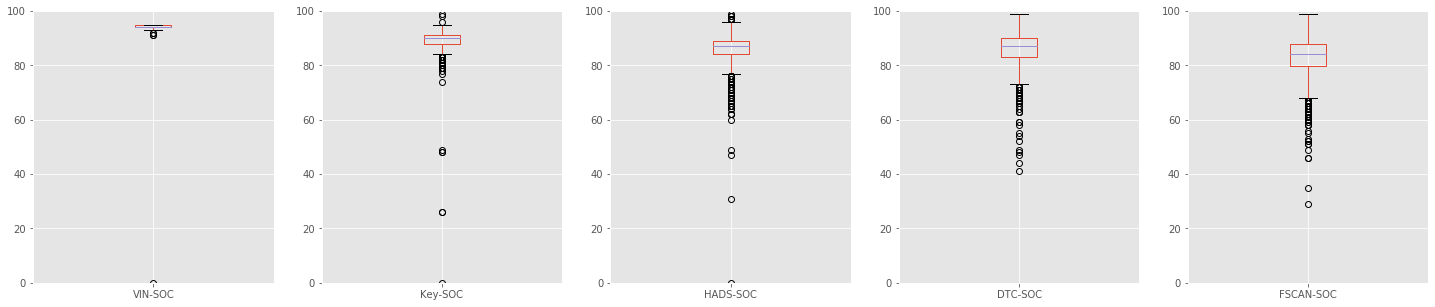

CK차종 공정별 SOC 분포


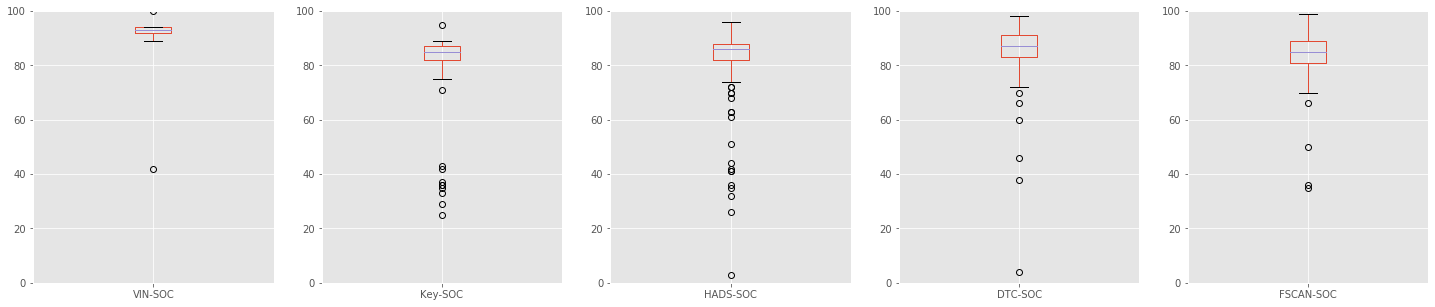

RJ차종 공정별 SOC 분포


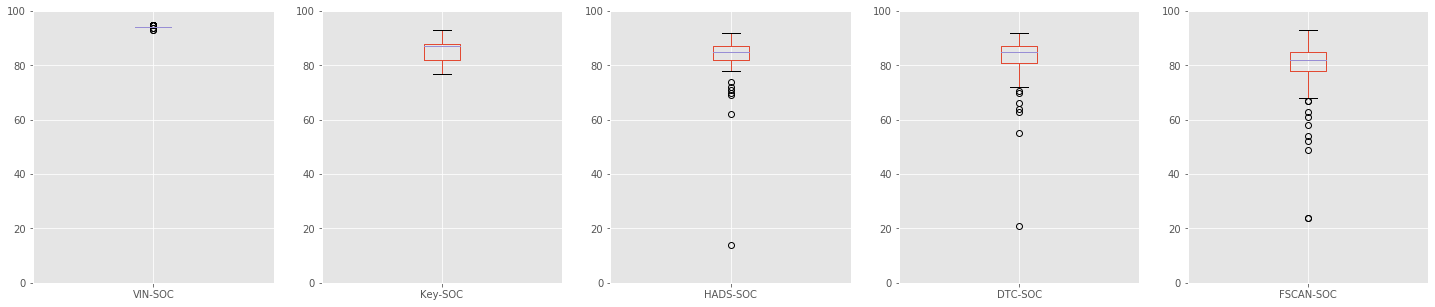

In [29]:
# YP - SOC 공정별 boxplot
print ('\033[1m' + '\033[34m' + 'YP차종 공정별 SOC 분포' + '\033[0m')

plt.figure(figsize=(25,5))
plt.subplot(151)
df2_yp.boxplot(column=['VIN-SOC'])
plt.ylim(0,100)
plt.subplot(152)
df2_yp.boxplot(column=['Key-SOC'])
plt.ylim(0,100)
plt.subplot(153)
df2_yp.boxplot(column=['HADS-SOC'])
plt.ylim(0,100)
plt.subplot(154)
df2_yp.boxplot(column=['DTC-SOC'])
plt.ylim(0,100)
plt.subplot(155)
df2_yp.boxplot(column=['FSCAN-SOC'])
plt.ylim(0,100)
plt.show()

# CK - SOC 공정별 boxplot
print ('\033[1m' + '\033[34m' + 'CK차종 공정별 SOC 분포' + '\033[0m')

plt.figure(figsize=(25,5))
plt.subplot(151)
df2_ck.boxplot(column=['VIN-SOC'])
plt.ylim(0,100)
plt.subplot(152)
df2_ck.boxplot(column=['Key-SOC'])
plt.ylim(0,100)
plt.subplot(153)
df2_ck.boxplot(column=['HADS-SOC'])
plt.ylim(0,100)
plt.subplot(154)
df2_ck.boxplot(column=['DTC-SOC'])
plt.ylim(0,100)
plt.subplot(155)
df2_ck.boxplot(column=['FSCAN-SOC'])
plt.ylim(0,100)
plt.show()

# RJ - SOC 공정별 boxplot
print ('\033[1m' + '\033[34m' + 'RJ차종 공정별 SOC 분포' + '\033[0m')

plt.figure(figsize=(25,5))
plt.subplot(151)
df2_rj.boxplot(column=['VIN-SOC'])
plt.ylim(0,100)
plt.subplot(152)
df2_rj.boxplot(column=['Key-SOC'])
plt.ylim(0,100)
plt.subplot(153)
df2_rj.boxplot(column=['HADS-SOC'])
plt.ylim(0,100)
plt.subplot(154)
df2_rj.boxplot(column=['DTC-SOC'])
plt.ylim(0,100)
plt.subplot(155)
df2_rj.boxplot(column=['FSCAN-SOC'])
plt.ylim(0,100)
plt.show()

# YP차종 구간별 summary / Graph

In [30]:
df2_yp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 40 columns):
Plant              1439 non-null object
Project            1439 non-null object
Body               1439 non-null object
Body_No            1439 non-null int64
VIN-VOL            1058 non-null float64
VIN-SOC            1058 non-null float64
VIN-SOH            1058 non-null float64
Key-VOL            1336 non-null object
Key-SOC            1325 non-null float64
Key-SOH            1337 non-null float64
HADS-VOL           1314 non-null object
HADS-SOC           1294 non-null float64
HADS-SOH           1310 non-null float64
DTC-VOL            1035 non-null object
DTC-SOC            876 non-null float64
DTC-SOH            1032 non-null float64
FSCAN-VOL          1317 non-null object
FSCAN-SOC          1312 non-null float64
FSCAN-SOH          0 non-null float64
(R)HADS-VOL        59 non-null object
(R)HADS-SOC        50 non-null float64
(R)HADS-SOH        59 non-null float64
(R)FSCAN-VO

In [31]:
# YP차종 구간별 DataFrame 생성 (A: VIN, B: Key, C: HADS, D: DTC, E: FSCAN)
df2_yp_AB = df2_yp[['Project','Body_No','VIN-SOC','Key-SOC','VIN-Time','Key-Time','SOC(Key-VIN)','Time(Key-VIN)']]
df2_yp_BC = df2_yp[['Project','Body_No','Key-SOC','HADS-SOC','Key-Time','HADS-Time','SOC(HADS-Key)','Time(HADS-Key)']]
df2_yp_CD = df2_yp[['Project','Body_No','HADS-SOC','DTC-SOC','HADS-Time','DTC-Time','SOC(DTC-HADS)','Time(DTC-HADS)']]
df2_yp_DE = df2_yp[['Project','Body_No','DTC-SOC','FSCAN-SOC','DTC-Time','FSCAN-Time','SOC(FSCAN-DTC)','Time(FSCAN-DTC)']]

# 컬럼명 rename
df2_yp_AB.columns = ['Project','Body_No','A-SOC','B-SOC','A-Time','B-Time','AB-SOC','AB-Time']
df2_yp_BC.columns = ['Project','Body_No','B-SOC','C-SOC','B-Time','C-Time','BC-SOC','BC-Time']
df2_yp_CD.columns = ['Project','Body_No','C-SOC','D-SOC','C-Time','D-Time','CD-SOC','CD-Time']
df2_yp_DE.columns = ['Project','Body_No','D-SOC','E-SOC','D-Time','E-Time','DE-SOC','DE-Time']

# NA값 Drop 하기
df2_yp_AB = df2_yp_AB.dropna()
df2_yp_BC = df2_yp_BC.dropna()
df2_yp_CD = df2_yp_CD.dropna()
df2_yp_DE = df2_yp_DE.dropna()

# 인덱스 값 리셋하기, index 열 삭제
df2_yp_AB = df2_yp_AB.reset_index()
df2_yp_BC = df2_yp_BC.reset_index()
df2_yp_CD = df2_yp_CD.reset_index()
df2_yp_DE = df2_yp_DE.reset_index()
df2_yp_AB = df2_yp_AB.drop('index', axis=1)
df2_yp_BC = df2_yp_BC.drop('index', axis=1)
df2_yp_CD = df2_yp_CD.drop('index', axis=1)
df2_yp_DE = df2_yp_DE.drop('index', axis=1)

df2_yp_AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 8 columns):
Project    1023 non-null object
Body_No    1023 non-null int64
A-SOC      1023 non-null float64
B-SOC      1023 non-null float64
A-Time     1023 non-null datetime64[ns]
B-Time     1023 non-null datetime64[ns]
AB-SOC     1023 non-null float64
AB-Time    1023 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1), timedelta64[ns](1)
memory usage: 64.1+ KB


In [32]:
# Timedelta로 나누어 int로 변경
df2_yp_AB['AB-Time(s)'] = df2_yp_AB['AB-Time']/pd.Timedelta(seconds=1)
df2_yp_BC['BC-Time(s)'] = df2_yp_BC['BC-Time']/pd.Timedelta(seconds=1)
df2_yp_CD['CD-Time(s)'] = df2_yp_CD['CD-Time']/pd.Timedelta(seconds=1)
df2_yp_DE['DE-Time(s)'] = df2_yp_DE['DE-Time']/pd.Timedelta(seconds=1)

df2_yp_AB.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 9 columns):
Project       1023 non-null object
Body_No       1023 non-null int64
A-SOC         1023 non-null float64
B-SOC         1023 non-null float64
A-Time        1023 non-null datetime64[ns]
B-Time        1023 non-null datetime64[ns]
AB-SOC        1023 non-null float64
AB-Time       1023 non-null timedelta64[ns]
AB-Time(s)    1023 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(1), object(1), timedelta64[ns](1)
memory usage: 72.1+ KB


In [33]:
# Perform Linear regression
yp_X_AB = df2_yp_AB['AB-Time(s)'].loc[:].values.reshape(-1,1)
yp_Y_AB = df2_yp_AB['AB-SOC'].loc[:].values.reshape(-1,1)
yp_lr_AB = LinearRegression()
yp_lr_AB.fit(yp_X_AB,yp_Y_AB)
yp_Y_pred_AB = yp_lr_AB.predict(yp_X_AB)

yp_X_BC = df2_yp_BC['BC-Time(s)'].loc[:].values.reshape(-1,1)
yp_Y_BC = df2_yp_BC['BC-SOC'].loc[:].values.reshape(-1,1)
yp_lr_BC = LinearRegression()
yp_lr_BC.fit(yp_X_BC,yp_Y_BC)
yp_Y_pred_BC = yp_lr_BC.predict(yp_X_BC)

yp_X_CD = df2_yp_CD['CD-Time(s)'].loc[:].values.reshape(-1,1)
yp_Y_CD = df2_yp_CD['CD-SOC'].loc[:].values.reshape(-1,1)
yp_lr_CD = LinearRegression()
yp_lr_CD.fit(yp_X_CD,yp_Y_CD)
yp_Y_pred_CD = yp_lr_CD.predict(yp_X_CD)

yp_X_DE = df2_yp_DE['DE-Time(s)'].loc[:].values.reshape(-1,1)
yp_Y_DE = df2_yp_DE['DE-SOC'].loc[:].values.reshape(-1,1)
yp_lr_DE = LinearRegression()
yp_lr_DE.fit(yp_X_DE,yp_Y_DE)
yp_Y_pred_DE = yp_lr_DE.predict(yp_X_DE)

In [34]:
# YP차종 공정별 통계 수치 추가
df2_yp_summary.iloc[0,11] = round(df2_yp_AB['AB-SOC'].max(),2)
df2_yp_summary.iloc[1,11] = round(df2_yp_AB['AB-SOC'].mean(),2)
df2_yp_summary.iloc[2,11] = round(df2_yp_AB['AB-SOC'].std(),2)
df2_yp_summary.iloc[3,11] = round(df2_yp_AB['AB-SOC'].min(),2)
df2_yp_summary.iloc[0,12] = round(df2_yp_BC['BC-SOC'].max(),2)
df2_yp_summary.iloc[1,12] = round(df2_yp_BC['BC-SOC'].mean(),2)
df2_yp_summary.iloc[2,12] = round(df2_yp_BC['BC-SOC'].std(),2)
df2_yp_summary.iloc[3,12] = round(df2_yp_BC['BC-SOC'].min(),2)
df2_yp_summary.iloc[0,13] = round(df2_yp_CD['CD-SOC'].max(),2)
df2_yp_summary.iloc[1,13] = round(df2_yp_CD['CD-SOC'].mean(),2)
df2_yp_summary.iloc[2,13] = round(df2_yp_CD['CD-SOC'].std(),2)
df2_yp_summary.iloc[3,13] = round(df2_yp_CD['CD-SOC'].min(),2)
df2_yp_summary.iloc[0,14] = round(df2_yp_DE['DE-SOC'].max(),2)
df2_yp_summary.iloc[1,14] = round(df2_yp_DE['DE-SOC'].mean(),2)
df2_yp_summary.iloc[2,14] = round(df2_yp_DE['DE-SOC'].std(),2)
df2_yp_summary.iloc[3,14] = round(df2_yp_DE['DE-SOC'].min(),2)

In [35]:
# 차종별 SOC 공정별 통계 수치값 확인
print ('\033[1m' + '\033[34m' + 'YP차종 공정별 SOC 통계 수치' + '\033[0m')
print (df2_yp_summary)

YP차종 공정별 SOC 통계 수치
       VIN    Key   HADS    DTC  FSCAN (R)HADS (R)FSCAN Key-VIN HADS-Key  \
Max     95     99     99     99     99     100       89       4       17   
평균   94.27  88.81  86.08  85.51  82.73   86.32     82.8    -5.6    -2.44   
편차    2.96    4.7   5.79   7.07   7.83    8.69     3.77    4.14     3.84   
Min      0      0      0     41     29      50       79     -68      -37   

    DTC-HADS FSCAN-DTC    AB    BC    CD   DE  
Max       94        12     4    17    94   12  
평균     -0.63      -1.9  -5.6 -2.42 -0.63 -1.9  
편차      6.61       3.2  4.14   3.8  6.61  3.2  
Min      -46       -23   -68   -37   -46  -23  


YP차종 공정간 SOC 변화량
Key-VIN 구간 기울기= [[-0.00041435]] 절편= [-4.22335054]
HADS-Key 구간 기울기= [[-6.15401961e-05]] 절편= [-2.19781256]
DTC-HADS 구간 기울기= [[-0.00013191]] 절편= [0.02656952]
FSCAN-DTC 구간 기울기= [[-0.00013528]] 절편= [-1.06812901]


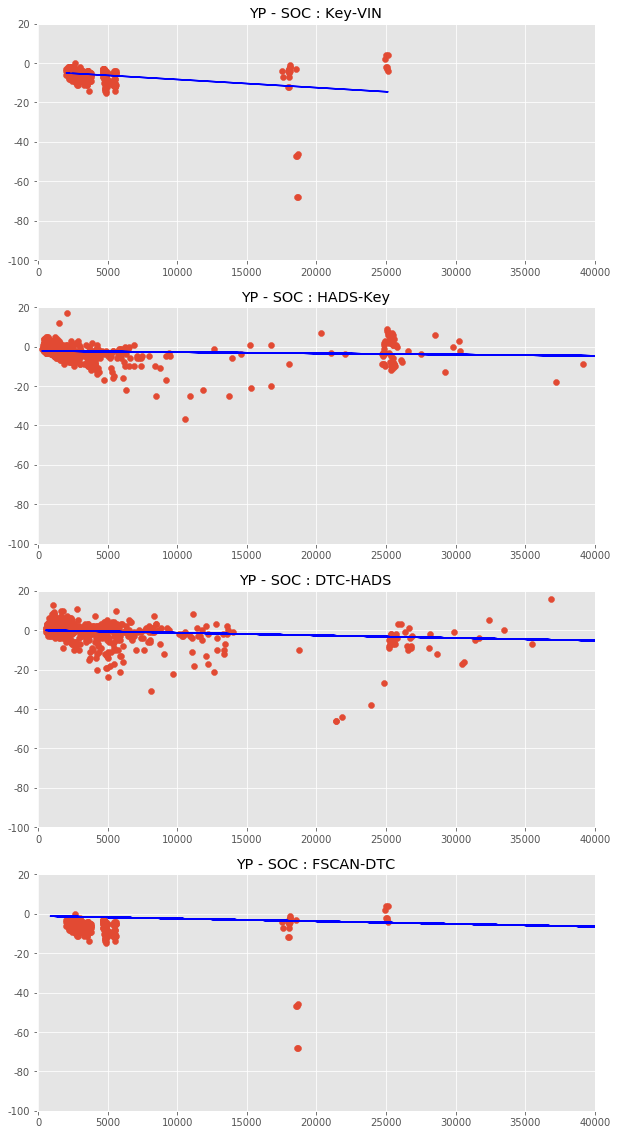

In [36]:
# Visualize results
# YP 차종 공정구간 SOC차이
print ('\033[1m' + '\033[34m' + 'YP차종 공정간 SOC 변화량' + '\033[0m')
print ('Key-VIN 구간 기울기=',yp_lr_AB.coef_, '절편=',yp_lr_AB.intercept_)
print ('HADS-Key 구간 기울기=',yp_lr_BC.coef_, '절편=',yp_lr_BC.intercept_)
print ('DTC-HADS 구간 기울기=',yp_lr_CD.coef_, '절편=',yp_lr_CD.intercept_)
print ('FSCAN-DTC 구간 기울기=',yp_lr_DE.coef_, '절편=',yp_lr_DE.intercept_)

plt.figure(figsize=(10,20))

plt.subplot(411)
plt.scatter(yp_X_AB,yp_Y_AB)
plt.plot(yp_X_AB, yp_Y_pred_AB, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('YP - SOC : Key-VIN')

plt.subplot(412)
plt.scatter(yp_X_BC,yp_Y_BC)
plt.plot(yp_X_BC, yp_Y_pred_BC, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('YP - SOC : HADS-Key')

plt.subplot(413)
plt.scatter(yp_X_CD,yp_Y_CD)
plt.plot(yp_X_CD, yp_Y_pred_CD, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('YP - SOC : DTC-HADS')

plt.subplot(414)
plt.scatter(yp_X_AB,yp_Y_AB)
plt.plot(yp_X_DE, yp_Y_pred_DE, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('YP - SOC : FSCAN-DTC')

plt.show()

# CK차종 구간별 summary / Graph

In [37]:
# CK차종 구간별 DataFrame 생성 (A: VIN, B: Key, C: HADS, D: DTC, E: FSCAN)
df2_ck_AB = df2_ck[['Project','Body_No','VIN-SOC','Key-SOC','VIN-Time','Key-Time','SOC(Key-VIN)','Time(Key-VIN)']]
df2_ck_BC = df2_ck[['Project','Body_No','Key-SOC','HADS-SOC','Key-Time','HADS-Time','SOC(HADS-Key)','Time(HADS-Key)']]
df2_ck_CD = df2_ck[['Project','Body_No','HADS-SOC','DTC-SOC','HADS-Time','DTC-Time','SOC(DTC-HADS)','Time(DTC-HADS)']]
df2_ck_DE = df2_ck[['Project','Body_No','DTC-SOC','FSCAN-SOC','DTC-Time','FSCAN-Time','SOC(FSCAN-DTC)','Time(FSCAN-DTC)']]

# 컬럼명 rename
df2_ck_AB.columns = ['Project','Body_No','A-SOC','B-SOC','A-Time','B-Time','AB-SOC','AB-Time']
df2_ck_BC.columns = ['Project','Body_No','B-SOC','C-SOC','B-Time','C-Time','BC-SOC','BC-Time']
df2_ck_CD.columns = ['Project','Body_No','C-SOC','D-SOC','C-Time','D-Time','CD-SOC','CD-Time']
df2_ck_DE.columns = ['Project','Body_No','D-SOC','E-SOC','D-Time','E-Time','DE-SOC','DE-Time']

# NA값 Drop 하기
df2_ck_AB = df2_ck_AB.dropna()
df2_ck_BC = df2_ck_BC.dropna()
df2_ck_CD = df2_ck_CD.dropna()
df2_ck_DE = df2_ck_DE.dropna()

# 인덱스 값 리셋하기, index 열 삭제
df2_ck_AB = df2_ck_AB.reset_index()
df2_ck_BC = df2_ck_BC.reset_index()
df2_ck_CD = df2_ck_CD.reset_index()
df2_ck_DE = df2_ck_DE.reset_index()
df2_ck_AB = df2_ck_AB.drop('index', axis=1)
df2_ck_BC = df2_ck_BC.drop('index', axis=1)
df2_ck_CD = df2_ck_CD.drop('index', axis=1)
df2_ck_DE = df2_ck_DE.drop('index', axis=1)

# Timedelta로 나누어 int로 변경
df2_ck_AB['AB-Time(s)'] = df2_ck_AB['AB-Time']/pd.Timedelta(seconds=1)
df2_ck_BC['BC-Time(s)'] = df2_ck_BC['BC-Time']/pd.Timedelta(seconds=1)
df2_ck_CD['CD-Time(s)'] = df2_ck_CD['CD-Time']/pd.Timedelta(seconds=1)
df2_ck_DE['DE-Time(s)'] = df2_ck_DE['DE-Time']/pd.Timedelta(seconds=1)
    
# Perform Linear regression
ck_X_AB = df2_ck_AB['AB-Time(s)'].loc[:].values.reshape(-1,1)
ck_Y_AB = df2_ck_AB['AB-SOC'].loc[:].values.reshape(-1,1)
ck_lr_AB = LinearRegression()
ck_lr_AB.fit(ck_X_AB,ck_Y_AB)
ck_Y_pred_AB = ck_lr_AB.predict(ck_X_AB)

ck_X_BC = df2_ck_BC['BC-Time(s)'].loc[:].values.reshape(-1,1)
ck_Y_BC = df2_ck_BC['BC-SOC'].loc[:].values.reshape(-1,1)
ck_lr_BC = LinearRegression()
ck_lr_BC.fit(ck_X_BC,ck_Y_BC)
ck_Y_pred_BC = ck_lr_BC.predict(ck_X_BC)

ck_X_CD = df2_ck_CD['CD-Time(s)'].loc[:].values.reshape(-1,1)
ck_Y_CD = df2_ck_CD['CD-SOC'].loc[:].values.reshape(-1,1)
ck_lr_CD = LinearRegression()
ck_lr_CD.fit(ck_X_CD,ck_Y_CD)
ck_Y_pred_CD = ck_lr_CD.predict(ck_X_CD)

ck_X_DE = df2_ck_DE['DE-Time(s)'].loc[:].values.reshape(-1,1)
ck_Y_DE = df2_ck_DE['DE-SOC'].loc[:].values.reshape(-1,1)
ck_lr_DE = LinearRegression()
ck_lr_DE.fit(ck_X_DE,ck_Y_DE)
ck_Y_pred_DE = ck_lr_DE.predict(ck_X_DE)

# ck차종 공정별 통계 수치 추가
df2_ck_summary.iloc[0,11] = round(df2_ck_AB['AB-SOC'].max(),2)
df2_ck_summary.iloc[1,11] = round(df2_ck_AB['AB-SOC'].mean(),2)
df2_ck_summary.iloc[2,11] = round(df2_ck_AB['AB-SOC'].std(),2)
df2_ck_summary.iloc[3,11] = round(df2_ck_AB['AB-SOC'].min(),2)
df2_ck_summary.iloc[0,12] = round(df2_ck_BC['BC-SOC'].max(),2)
df2_ck_summary.iloc[1,12] = round(df2_ck_BC['BC-SOC'].mean(),2)
df2_ck_summary.iloc[2,12] = round(df2_ck_BC['BC-SOC'].std(),2)
df2_ck_summary.iloc[3,12] = round(df2_ck_BC['BC-SOC'].min(),2)
df2_ck_summary.iloc[0,13] = round(df2_ck_CD['CD-SOC'].max(),2)
df2_ck_summary.iloc[1,13] = round(df2_ck_CD['CD-SOC'].mean(),2)
df2_ck_summary.iloc[2,13] = round(df2_ck_CD['CD-SOC'].std(),2)
df2_ck_summary.iloc[3,13] = round(df2_ck_CD['CD-SOC'].min(),2)
df2_ck_summary.iloc[0,14] = round(df2_ck_DE['DE-SOC'].max(),2)
df2_ck_summary.iloc[1,14] = round(df2_ck_DE['DE-SOC'].mean(),2)
df2_ck_summary.iloc[2,14] = round(df2_ck_DE['DE-SOC'].std(),2)
df2_ck_summary.iloc[3,14] = round(df2_ck_DE['DE-SOC'].min(),2)

In [38]:
df2_ck_AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 9 columns):
Project       332 non-null object
Body_No       332 non-null int64
A-SOC         332 non-null float64
B-SOC         332 non-null float64
A-Time        332 non-null datetime64[ns]
B-Time        332 non-null datetime64[ns]
AB-SOC        332 non-null float64
AB-Time       332 non-null timedelta64[ns]
AB-Time(s)    332 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(1), object(1), timedelta64[ns](1)
memory usage: 23.5+ KB


In [39]:
# 차종별 SOC 공정별 통계 수치값 확인
print ('\033[1m' + '\033[34m' + 'CK차종 공정별 SOC 통계 수치' + '\033[0m')
print (df2_ck_summary)

CK차종 공정별 SOC 통계 수치
       VIN    Key   HADS    DTC  FSCAN (R)HADS (R)FSCAN Key-VIN HADS-Key  \
Max    100     95     96     98     99      96       78      -4       14   
평균   92.94  83.43  83.79  86.18  84.62    86.5       78   -8.81     0.56   
편차    2.97   7.63   8.84   7.46   6.96    7.04      NaN    3.04     3.54   
Min     42     25      3      4     35      63       78     -21      -22   

    DTC-HADS FSCAN-DTC    AB    BC    CD    DE  
Max       54        32    -4    14    54    32  
평균      2.08     -1.66 -8.81  0.56  2.08 -1.66  
편차      5.95      2.79  3.04  3.54  5.95  2.79  
Min      -19       -14   -21   -22   -19   -14  


CK차종 공정간 SOC 변화량
Key-VIN 구간 기울기= [[-1.3188619e-05]] 절편= [-8.75630662]
HADS-Key 구간 기울기= [[-8.63634853e-05]] 절편= [0.97905028]
DTC-HADS 구간 기울기= [[-8.71375874e-05]] 절편= [2.45156001]
FSCAN-DTC 구간 기울기= [[-8.17509997e-06]] 절편= [-1.57018096]


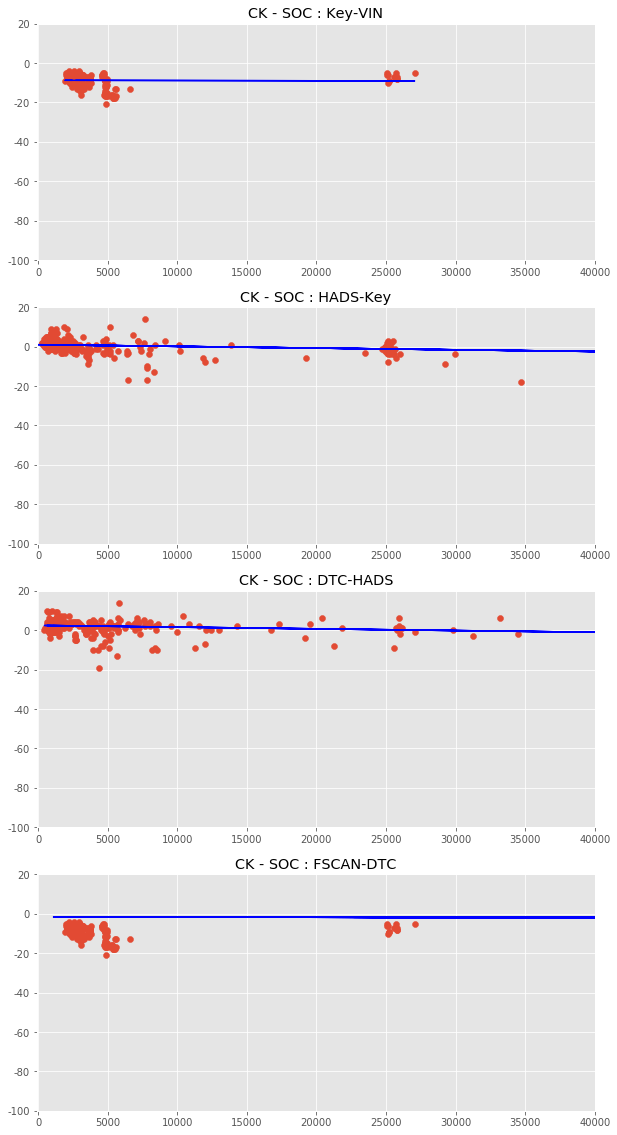

In [40]:
# Visualize results
# CK 차종 공정구간 SOC차이
print ('\033[1m' + '\033[34m' + 'CK차종 공정간 SOC 변화량' + '\033[0m')
print ('Key-VIN 구간 기울기=',ck_lr_AB.coef_, '절편=',ck_lr_AB.intercept_)
print ('HADS-Key 구간 기울기=',ck_lr_BC.coef_, '절편=',ck_lr_BC.intercept_)
print ('DTC-HADS 구간 기울기=',ck_lr_CD.coef_, '절편=',ck_lr_CD.intercept_)
print ('FSCAN-DTC 구간 기울기=',ck_lr_DE.coef_, '절편=',ck_lr_DE.intercept_)

plt.figure(figsize=(10,20))

plt.subplot(411)
plt.scatter(ck_X_AB,ck_Y_AB)
plt.plot(ck_X_AB, ck_Y_pred_AB, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('CK - SOC : Key-VIN')

plt.subplot(412)
plt.scatter(ck_X_BC,ck_Y_BC)
plt.plot(ck_X_BC, ck_Y_pred_BC, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('CK - SOC : HADS-Key')

plt.subplot(413)
plt.scatter(ck_X_CD,ck_Y_CD)
plt.plot(ck_X_CD, ck_Y_pred_CD, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('CK - SOC : DTC-HADS')

plt.subplot(414)
plt.scatter(ck_X_AB,ck_Y_AB)
plt.plot(ck_X_DE, ck_Y_pred_DE, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('CK - SOC : FSCAN-DTC')

plt.show()

# RJ차종 구간별 summary / Graph

In [41]:
# RJ차종 구간별 DataFrame 생성 (A: VIN, B: Key, C: HADS, D: DTC, E: FSCAN)
df2_rj_AB = df2_rj[['Project','Body_No','VIN-SOC','Key-SOC','VIN-Time','Key-Time','SOC(Key-VIN)','Time(Key-VIN)']]
df2_rj_BC = df2_rj[['Project','Body_No','Key-SOC','HADS-SOC','Key-Time','HADS-Time','SOC(HADS-Key)','Time(HADS-Key)']]
df2_rj_CD = df2_rj[['Project','Body_No','HADS-SOC','DTC-SOC','HADS-Time','DTC-Time','SOC(DTC-HADS)','Time(DTC-HADS)']]
df2_rj_DE = df2_rj[['Project','Body_No','DTC-SOC','FSCAN-SOC','DTC-Time','FSCAN-Time','SOC(FSCAN-DTC)','Time(FSCAN-DTC)']]

# 컬럼명 rename
df2_rj_AB.columns = ['Project','Body_No','A-SOC','B-SOC','A-Time','B-Time','AB-SOC','AB-Time']
df2_rj_BC.columns = ['Project','Body_No','B-SOC','C-SOC','B-Time','C-Time','BC-SOC','BC-Time']
df2_rj_CD.columns = ['Project','Body_No','C-SOC','D-SOC','C-Time','D-Time','CD-SOC','CD-Time']
df2_rj_DE.columns = ['Project','Body_No','D-SOC','E-SOC','D-Time','E-Time','DE-SOC','DE-Time']

# NA값 Drop 하기
df2_rj_AB = df2_rj_AB.dropna()
df2_rj_BC = df2_rj_BC.dropna()
df2_rj_CD = df2_rj_CD.dropna()
df2_rj_DE = df2_rj_DE.dropna()

# 인덱스 값 리셋하기, index 열 삭제
df2_rj_AB = df2_rj_AB.reset_index()
df2_rj_BC = df2_rj_BC.reset_index()
df2_rj_CD = df2_rj_CD.reset_index()
df2_rj_DE = df2_rj_DE.reset_index()
df2_rj_AB = df2_rj_AB.drop('index', axis=1)
df2_rj_BC = df2_rj_BC.drop('index', axis=1)
df2_rj_CD = df2_rj_CD.drop('index', axis=1)
df2_rj_DE = df2_rj_DE.drop('index', axis=1)

# Timedelta로 나누어 int로 변경
df2_rj_AB['AB-Time(s)'] = df2_rj_AB['AB-Time']/pd.Timedelta(seconds=1)
df2_rj_BC['BC-Time(s)'] = df2_rj_BC['BC-Time']/pd.Timedelta(seconds=1)
df2_rj_CD['CD-Time(s)'] = df2_rj_CD['CD-Time']/pd.Timedelta(seconds=1)
df2_rj_DE['DE-Time(s)'] = df2_rj_DE['DE-Time']/pd.Timedelta(seconds=1)
    
# Perform Linear regression
rj_X_AB = df2_rj_AB['AB-Time(s)'].loc[:].values.reshape(-1,1)
rj_Y_AB = df2_rj_AB['AB-SOC'].loc[:].values.reshape(-1,1)
rj_lr_AB = LinearRegression()
rj_lr_AB.fit(rj_X_AB,rj_Y_AB)
rj_Y_pred_AB = rj_lr_AB.predict(rj_X_AB)

rj_X_BC = df2_rj_BC['BC-Time(s)'].loc[:].values.reshape(-1,1)
rj_Y_BC = df2_rj_BC['BC-SOC'].loc[:].values.reshape(-1,1)
rj_lr_BC = LinearRegression()
rj_lr_BC.fit(rj_X_BC,rj_Y_BC)
rj_Y_pred_BC = rj_lr_BC.predict(rj_X_BC)

rj_X_CD = df2_rj_CD['CD-Time(s)'].loc[:].values.reshape(-1,1)
rj_Y_CD = df2_rj_CD['CD-SOC'].loc[:].values.reshape(-1,1)
rj_lr_CD = LinearRegression()
rj_lr_CD.fit(rj_X_CD,rj_Y_CD)
rj_Y_pred_CD = rj_lr_CD.predict(rj_X_CD)

rj_X_DE = df2_rj_DE['DE-Time(s)'].loc[:].values.reshape(-1,1)
rj_Y_DE = df2_rj_DE['DE-SOC'].loc[:].values.reshape(-1,1)
rj_lr_DE = LinearRegression()
rj_lr_DE.fit(rj_X_DE,rj_Y_DE)
rj_Y_pred_DE = rj_lr_DE.predict(rj_X_DE)

# rj차종 공정별 통계 수치 추가
df2_rj_summary.iloc[0,11] = round(df2_rj_AB['AB-SOC'].max(),2)
df2_rj_summary.iloc[1,11] = round(df2_rj_AB['AB-SOC'].mean(),2)
df2_rj_summary.iloc[2,11] = round(df2_rj_AB['AB-SOC'].std(),2)
df2_rj_summary.iloc[3,11] = round(df2_rj_AB['AB-SOC'].min(),2)
df2_rj_summary.iloc[0,12] = round(df2_rj_BC['BC-SOC'].max(),2)
df2_rj_summary.iloc[1,12] = round(df2_rj_BC['BC-SOC'].mean(),2)
df2_rj_summary.iloc[2,12] = round(df2_rj_BC['BC-SOC'].std(),2)
df2_rj_summary.iloc[3,12] = round(df2_rj_BC['BC-SOC'].min(),2)
df2_rj_summary.iloc[0,13] = round(df2_rj_CD['CD-SOC'].max(),2)
df2_rj_summary.iloc[1,13] = round(df2_rj_CD['CD-SOC'].mean(),2)
df2_rj_summary.iloc[2,13] = round(df2_rj_CD['CD-SOC'].std(),2)
df2_rj_summary.iloc[3,13] = round(df2_rj_CD['CD-SOC'].min(),2)
df2_rj_summary.iloc[0,14] = round(df2_rj_DE['DE-SOC'].max(),2)
df2_rj_summary.iloc[1,14] = round(df2_rj_DE['DE-SOC'].mean(),2)
df2_rj_summary.iloc[2,14] = round(df2_rj_DE['DE-SOC'].std(),2)
df2_rj_summary.iloc[3,14] = round(df2_rj_DE['DE-SOC'].min(),2)

In [42]:
# 차종별 SOC 공정별 통계 수치값 확인
print ('\033[1m' + '\033[34m' + 'RJ차종 공정별 SOC 통계 수치' + '\033[0m')
print (df2_rj_summary)

RJ차종 공정별 SOC 통계 수치
       VIN    Key   HADS   DTC  FSCAN (R)HADS (R)FSCAN Key-VIN HADS-Key  \
Max     95     93     92    92     93      93       81      -2        4   
평균   94.19  85.71  83.69  82.3  79.75   83.68       80   -7.99    -1.45   
편차    0.44   3.98    7.4  8.31    9.7     7.9     1.41    3.81     4.05   
Min     93     77     14    21     24      50       79   -16.8      -27   

    DTC-HADS FSCAN-DTC    AB    BC     CD    DE  
Max       74         7    -2     4     74     7  
평균     -1.52     -2.47 -7.99 -1.45  -1.52 -2.47  
편차     10.14       4.6  3.81  4.05  10.14   4.6  
Min      -58       -36 -16.8   -27    -58   -36  


RJ차종 공정간 SOC 변화량
Key-VIN 구간 기울기= [[-0.00055611]] 절편= [-6.05770378]
HADS-Key 구간 기울기= [[-0.00017388]] 절편= [-0.35847198]
DTC-HADS 구간 기울기= [[2.41446875e-05]] 절편= [-1.70276907]
FSCAN-DTC 구간 기울기= [[-0.00018082]] 절편= [-0.86923675]


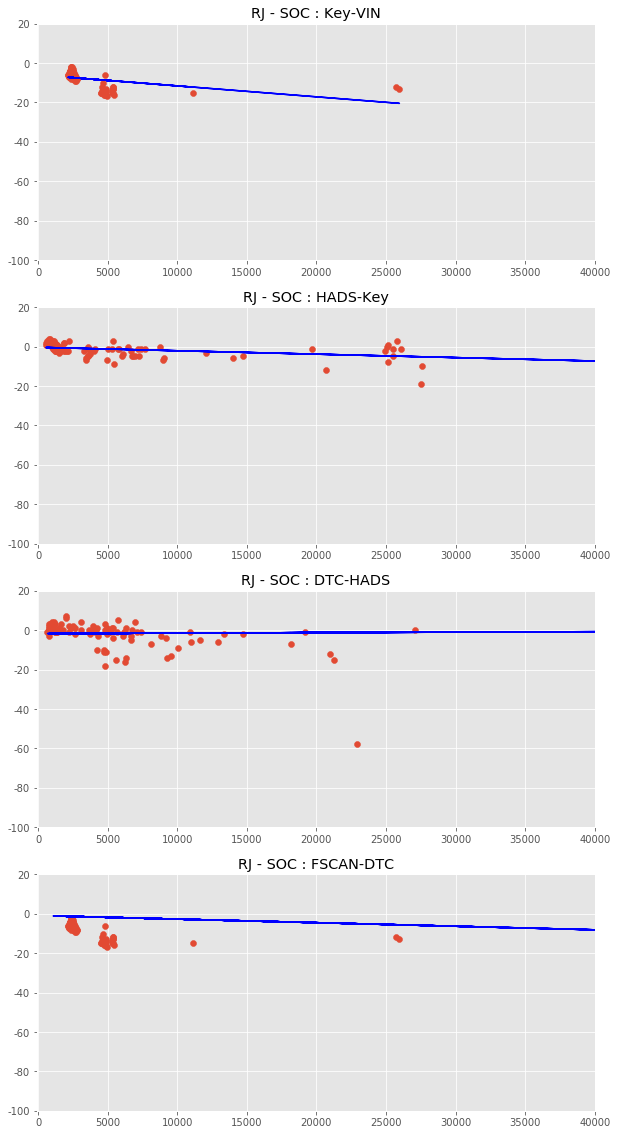

In [43]:
# Visualize results
# RJ 차종 공정구간 SOC차이
print ('\033[1m' + '\033[34m' + 'RJ차종 공정간 SOC 변화량' + '\033[0m')
print ('Key-VIN 구간 기울기=',rj_lr_AB.coef_, '절편=',rj_lr_AB.intercept_)
print ('HADS-Key 구간 기울기=',rj_lr_BC.coef_, '절편=',rj_lr_BC.intercept_)
print ('DTC-HADS 구간 기울기=',rj_lr_CD.coef_, '절편=',rj_lr_CD.intercept_)
print ('FSCAN-DTC 구간 기울기=',rj_lr_DE.coef_, '절편=',rj_lr_DE.intercept_)

plt.figure(figsize=(10,20))

plt.subplot(411)
plt.scatter(rj_X_AB,rj_Y_AB)
plt.plot(rj_X_AB, rj_Y_pred_AB, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('RJ - SOC : Key-VIN')

plt.subplot(412)
plt.scatter(rj_X_BC,rj_Y_BC)
plt.plot(rj_X_BC, rj_Y_pred_BC, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('RJ - SOC : HADS-Key')

plt.subplot(413)
plt.scatter(rj_X_CD,rj_Y_CD)
plt.plot(rj_X_CD, rj_Y_pred_CD, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('RJ - SOC : DTC-HADS')

plt.subplot(414)
plt.scatter(rj_X_AB,rj_Y_AB)
plt.plot(rj_X_DE, rj_Y_pred_DE, color='blue')
plt.xlim(-100,40000)
plt.ylim(-100,20)
plt.title('RJ - SOC : FSCAN-DTC')

plt.show()

# 화이널~OK라인 SOC 변화량 (2Hr)

In [44]:
df2_yp_AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 9 columns):
Project       1023 non-null object
Body_No       1023 non-null int64
A-SOC         1023 non-null float64
B-SOC         1023 non-null float64
A-Time        1023 non-null datetime64[ns]
B-Time        1023 non-null datetime64[ns]
AB-SOC        1023 non-null float64
AB-Time       1023 non-null timedelta64[ns]
AB-Time(s)    1023 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(1), object(1), timedelta64[ns](1)
memory usage: 72.1+ KB


In [45]:
# YP 화이널 ~ OK 라인 DataFrame 생성 (0~7200초 사이)
df2_yp_AB_2hr = df2_yp_AB[df2_yp_AB['AB-Time(s)'] < 7200]

# NA값 Drop 하기
df2_yp_AB_2hr = df2_yp_AB_2hr.dropna()

# 인덱스 값 리셋하기, index열 삭제
df2_yp_AB_2hr = df2_yp_AB_2hr.reset_index()
df2_yp_AB_2hr = df2_yp_AB_2hr.drop('index', axis=1)

# Timedelta로 나누어 int로 변경
df2_yp_AB_2hr['AB-Time(m)'] = df2_yp_AB_2hr['AB-Time']/pd.Timedelta(minutes=1)
    
# Perform Linear regression
yp_X_AB_2hr = df2_yp_AB_2hr['AB-Time(m)'].loc[:].values.reshape(-1,1)
yp_Y_AB_2hr = df2_yp_AB_2hr['AB-SOC'].loc[:].values.reshape(-1,1)
yp_lr_AB_2hr = LinearRegression()
yp_lr_AB_2hr.fit(yp_X_AB_2hr,yp_Y_AB_2hr)
yp_Y_pred_AB_2hr = yp_lr_AB_2hr.predict(yp_X_AB_2hr)

In [46]:
df2_yp_AB_2hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 10 columns):
Project       995 non-null object
Body_No       995 non-null int64
A-SOC         995 non-null float64
B-SOC         995 non-null float64
A-Time        995 non-null datetime64[ns]
B-Time        995 non-null datetime64[ns]
AB-SOC        995 non-null float64
AB-Time       995 non-null timedelta64[ns]
AB-Time(s)    995 non-null float64
AB-Time(m)    995 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(1), object(1), timedelta64[ns](1)
memory usage: 77.9+ KB


In [47]:
# CK 화이널 ~ OK 라인 DataFrame 생성 (0~7200초 사이)
df2_ck_AB_2hr = df2_ck_AB[df2_ck_AB['AB-Time(s)'] < 7200]
        
# NA값 Drop 하기
df2_ck_AB_2hr = df2_ck_AB_2hr.dropna()

# 인덱스 값 리셋하기, index열 삭제
df2_ck_AB_2hr = df2_ck_AB_2hr.reset_index()
df2_ck_AB_2hr = df2_ck_AB_2hr.drop('index', axis=1)

# Timedelta로 나누어 int로 변경
df2_ck_AB_2hr['AB-Time(m)'] = df2_ck_AB_2hr['AB-Time']/pd.Timedelta(minutes=1)
    
# Perform Linear regression
ck_X_AB_2hr = df2_ck_AB_2hr['AB-Time(m)'].loc[:].values.reshape(-1,1)
ck_Y_AB_2hr = df2_ck_AB_2hr['AB-SOC'].loc[:].values.reshape(-1,1)
ck_lr_AB_2hr = LinearRegression()
ck_lr_AB_2hr.fit(ck_X_AB_2hr,ck_Y_AB_2hr)
ck_Y_pred_AB_2hr = ck_lr_AB_2hr.predict(ck_X_AB_2hr)

In [48]:
# RJ 화이널 ~ OK 라인 DataFrame 생성 (0~7200초 사이)
df2_rj_AB_2hr = df2_rj_AB[df2_rj_AB['AB-Time(s)'] < 7200]

# NA값 Drop 하기
df2_rj_AB_2hr = df2_rj_AB_2hr.dropna()

# 인덱스 값 리셋하기, index열 삭제
df2_rj_AB_2hr = df2_rj_AB_2hr.reset_index()
df2_rj_AB_2hr = df2_rj_AB_2hr.drop('index', axis=1)

# Timedelta로 나누어 int로 변경
df2_rj_AB_2hr['AB-Time(m)'] = df2_rj_AB_2hr['AB-Time']/pd.Timedelta(minutes=1)
    
# Perform Linear regression
rj_X_AB_2hr = df2_rj_AB_2hr['AB-Time(m)'].loc[:].values.reshape(-1,1)
rj_Y_AB_2hr = df2_rj_AB_2hr['AB-SOC'].loc[:].values.reshape(-1,1)
rj_lr_AB_2hr = LinearRegression()
rj_lr_AB_2hr.fit(rj_X_AB_2hr,rj_Y_AB_2hr)
rj_Y_pred_AB_2hr = rj_lr_AB_2hr.predict(rj_X_AB_2hr)

화이널 ~ OK라인 공정간 SOC 변화량
YP Key-VIN 구간 기울기= [[-0.07807579]] 절편= [-1.69301538]
CK Key-VIN 구간 기울기= [[-0.12596436]] 절편= [-2.47362698]
RJ Key-VIN 구간 기울기= [[-0.18625345]] 절편= [1.52401967]


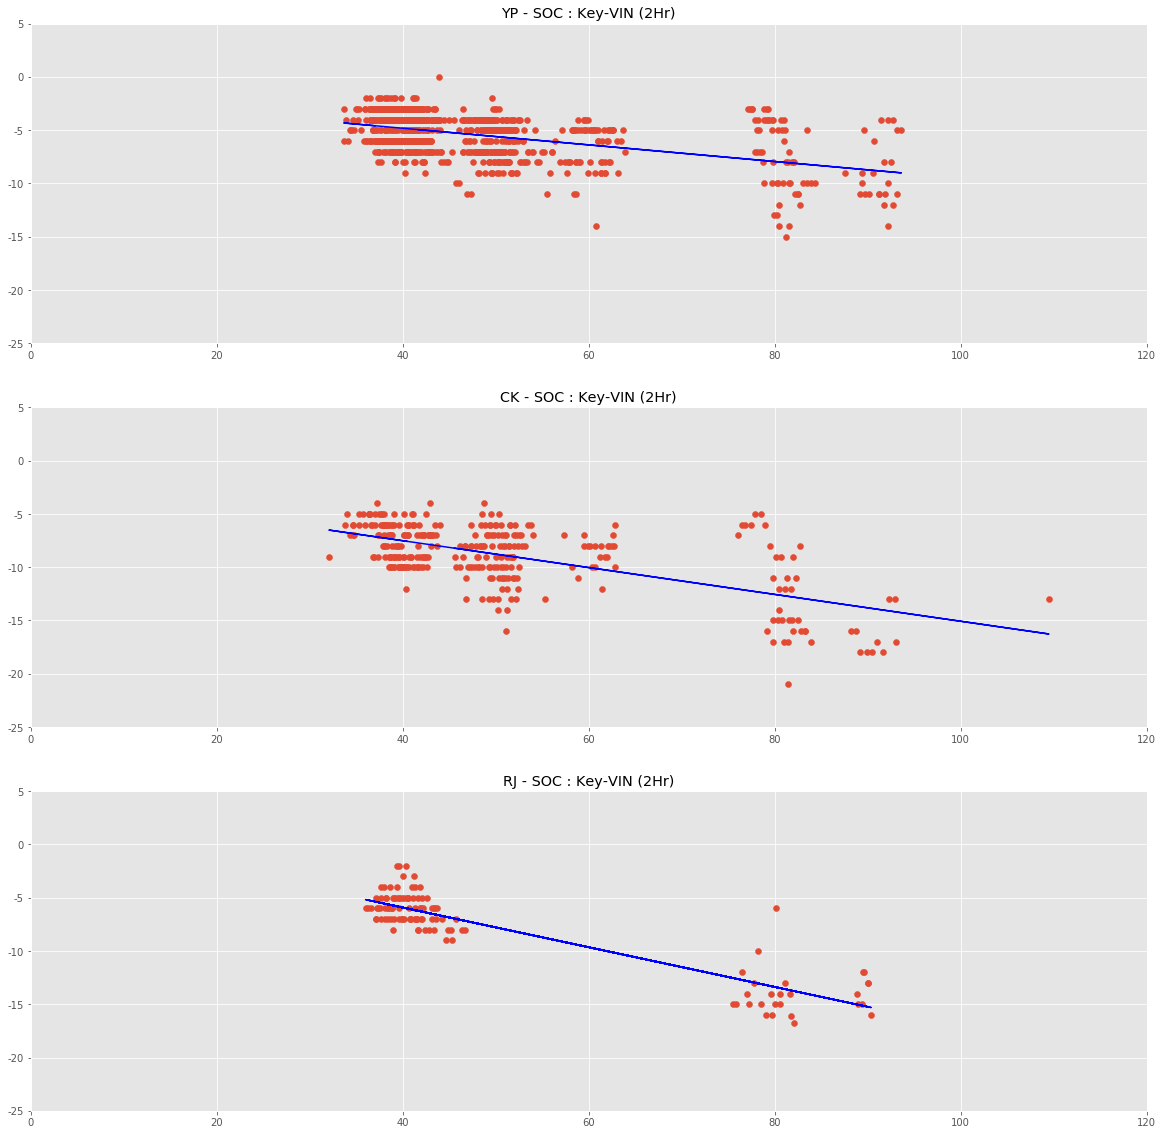

In [49]:
# YP차종
print ('\033[1m' + '\033[34m' + '화이널 ~ OK라인 공정간 SOC 변화량' + '\033[0m')
print ('YP Key-VIN 구간 기울기=',yp_lr_AB_2hr.coef_, '절편=',yp_lr_AB_2hr.intercept_)
print ('CK Key-VIN 구간 기울기=',ck_lr_AB_2hr.coef_, '절편=',ck_lr_AB_2hr.intercept_)
print ('RJ Key-VIN 구간 기울기=',rj_lr_AB_2hr.coef_, '절편=',rj_lr_AB_2hr.intercept_)

plt.figure(figsize=(20,20))

plt.subplot(311)
plt.scatter(yp_X_AB_2hr,yp_Y_AB_2hr)
plt.plot(yp_X_AB_2hr, yp_Y_pred_AB_2hr, color='blue')
plt.xlim(0,120)
plt.ylim(-25,5)
plt.title('YP - SOC : Key-VIN (2Hr)')

plt.subplot(312)
plt.scatter(ck_X_AB_2hr,ck_Y_AB_2hr)
plt.plot(ck_X_AB_2hr, ck_Y_pred_AB_2hr, color='blue')
plt.xlim(0,120)
plt.ylim(-25,5)
plt.title('CK - SOC : Key-VIN (2Hr)')

plt.subplot(313)
plt.scatter(rj_X_AB_2hr,rj_Y_AB_2hr)
plt.plot(rj_X_AB_2hr, rj_Y_pred_AB_2hr, color='blue')
plt.xlim(0,120)
plt.ylim(-25,5)
plt.title('RJ - SOC : Key-VIN (2Hr)')

plt.show()

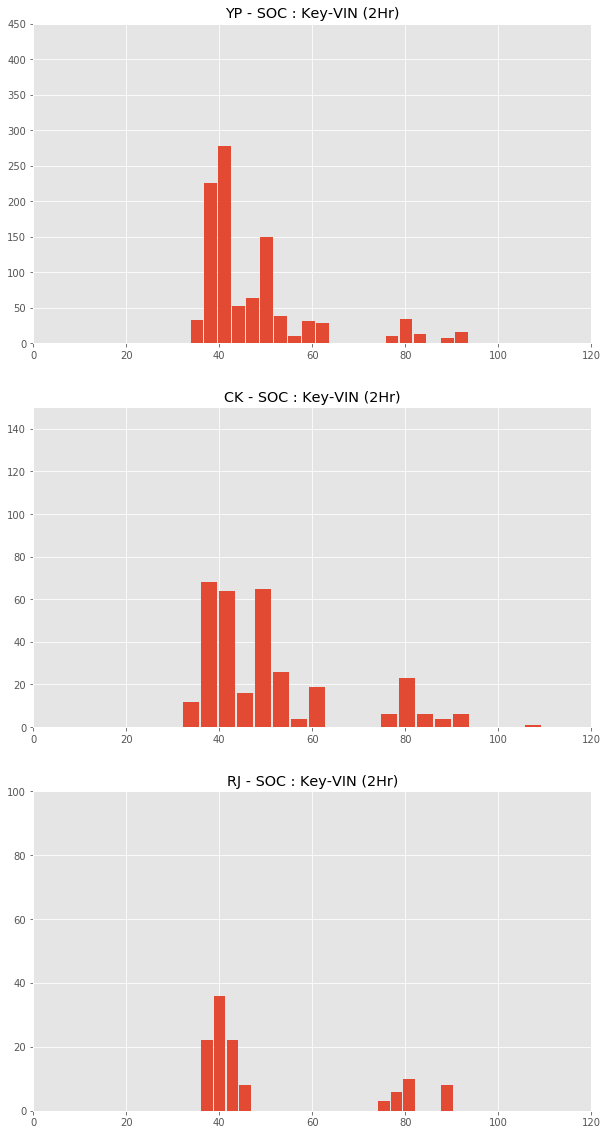

In [50]:
# 히스토그램
plt.figure(figsize=(10,20))

plt.subplot(311)
plt.hist(df2_yp_AB_2hr['AB-Time(m)'], 20, histtype='bar', rwidth=0.9)
plt.xlim(0,120)
plt.ylim(0,450)
plt.title('YP - SOC : Key-VIN (2Hr)')

plt.subplot(312)
plt.hist(df2_ck_AB_2hr['AB-Time(m)'], 20, histtype='bar', rwidth=0.9)
plt.xlim(0,120)
plt.ylim(0,150)
plt.title('CK - SOC : Key-VIN (2Hr)')

plt.subplot(313)
plt.hist(df2_rj_AB_2hr['AB-Time(m)'], 20, histtype='bar', rwidth=0.9)
plt.xlim(0,120)
plt.ylim(0,100)
plt.title('RJ - SOC : Key-VIN (2Hr)')

plt.show()

In [51]:
df2_yp_AB_2hr.head()

Project  Body_No  A-SOC  B-SOC              A-Time              B-Time  \
0      YP   646987   94.0   90.0 2020-02-06 17:51:01 2020-02-06 18:32:43   
1      YP   647290   94.0   89.0 2020-02-06 08:41:44 2020-02-06 09:31:17   
2      YP   647298   95.0   91.0 2020-02-06 12:34:12 2020-02-06 13:15:11   
3      YP   647302   94.0   91.0 2020-02-06 12:32:52 2020-02-06 13:11:07   
4      YP   647304   94.0   89.0 2020-02-06 12:35:28 2020-02-06 13:15:52   

   AB-SOC  AB-Time  AB-Time(s)  AB-Time(m)  
0    -4.0 00:41:42      2502.0   41.700000  
1    -5.0 00:49:33      2973.0   49.550000  
2    -4.0 00:40:59      2459.0   40.983333  
3    -3.0 00:38:15      2295.0   38.250000  
4    -5.0 00:40:24      2424.0   40.400000

In [52]:
# 중식시간 미포함/포함 DataFrame 생성 (A: VIN, B: Key, C: HADS, D: DTC, E: FSCAN)
df2_yp_AB_2hr_Before = df2_yp_AB_2hr[df2_yp_AB_2hr['AB-Time(m)'] < 70]
df2_yp_AB_2hr_After = df2_yp_AB_2hr[df2_yp_AB_2hr['AB-Time(m)'] > 70]
df2_ck_AB_2hr_Before = df2_ck_AB_2hr[df2_ck_AB_2hr['AB-Time(m)'] < 70]
df2_ck_AB_2hr_After = df2_ck_AB_2hr[df2_ck_AB_2hr['AB-Time(m)'] > 70]
df2_rj_AB_2hr_Before = df2_rj_AB_2hr[df2_rj_AB_2hr['AB-Time(m)'] < 70]
df2_rj_AB_2hr_After = df2_rj_AB_2hr[df2_rj_AB_2hr['AB-Time(m)'] > 70]

# NA값 Drop 하기
df2_yp_AB_2hr_Before = df2_yp_AB_2hr_Before.dropna()
df2_yp_AB_2hr_After = df2_yp_AB_2hr_After.dropna()
df2_ck_AB_2hr_Before = df2_ck_AB_2hr_Before.dropna()
df2_ck_AB_2hr_After = df2_ck_AB_2hr_After.dropna()
df2_rj_AB_2hr_Before = df2_rj_AB_2hr_Before.dropna()
df2_rj_AB_2hr_After = df2_rj_AB_2hr_After.dropna()

# 인덱스 값 리셋하기, index 엵 삭제
df2_yp_AB_2hr_Before = df2_yp_AB_2hr_Before.reset_index()
df2_yp_AB_2hr_After = df2_yp_AB_2hr_After.reset_index()
df2_ck_AB_2hr_Before = df2_ck_AB_2hr_Before.reset_index()
df2_ck_AB_2hr_After = df2_ck_AB_2hr_After.reset_index()
df2_rj_AB_2hr_Before = df2_rj_AB_2hr_Before.reset_index()
df2_rj_AB_2hr_After = df2_rj_AB_2hr_After.reset_index()
df2_yp_AB_2hr_Before = df2_yp_AB_2hr_Before.drop('index', axis=1)
df2_yp_AB_2hr_After = df2_yp_AB_2hr_After.drop('index', axis=1)
df2_ck_AB_2hr_Before = df2_ck_AB_2hr_Before.drop('index', axis=1)
df2_ck_AB_2hr_After = df2_ck_AB_2hr_After.drop('index', axis=1)
df2_rj_AB_2hr_Before = df2_rj_AB_2hr_Before.drop('index', axis=1)
df2_rj_AB_2hr_After = df2_rj_AB_2hr_After.drop('index', axis=1)

In [53]:
# AB구간 SOC값 min, max, 평균, 편차 데이터프레임 만들기
df2_AB_summary = pd.DataFrame(index = ['Max','평균','편차','Min'], columns = ['YP-Before','YP-After','CK-Before','CK-After','RJ-Before','RJ-After'])

In [54]:
# AB구간 공정별 통계 수치 추가
df2_AB_summary.iloc[0,0] = round(df2_yp_AB_2hr_Before['AB-SOC'].max(),2)
df2_AB_summary.iloc[1,0] = round(df2_yp_AB_2hr_Before['AB-SOC'].mean(),2)
df2_AB_summary.iloc[2,0] = round(df2_yp_AB_2hr_Before['AB-SOC'].std(),2)
df2_AB_summary.iloc[3,0] = round(df2_yp_AB_2hr_Before['AB-SOC'].min(),2)
df2_AB_summary.iloc[0,1] = round(df2_yp_AB_2hr_After['AB-SOC'].max(),2)
df2_AB_summary.iloc[1,1] = round(df2_yp_AB_2hr_After['AB-SOC'].mean(),2)
df2_AB_summary.iloc[2,1] = round(df2_yp_AB_2hr_After['AB-SOC'].std(),2)
df2_AB_summary.iloc[3,1] = round(df2_yp_AB_2hr_After['AB-SOC'].min(),2)
df2_AB_summary.iloc[0,2] = round(df2_ck_AB_2hr_Before['AB-SOC'].max(),2)
df2_AB_summary.iloc[1,2] = round(df2_ck_AB_2hr_Before['AB-SOC'].mean(),2)
df2_AB_summary.iloc[2,2] = round(df2_ck_AB_2hr_Before['AB-SOC'].std(),2)
df2_AB_summary.iloc[3,2] = round(df2_ck_AB_2hr_Before['AB-SOC'].min(),2)
df2_AB_summary.iloc[0,3] = round(df2_ck_AB_2hr_After['AB-SOC'].max(),2)
df2_AB_summary.iloc[1,3] = round(df2_ck_AB_2hr_After['AB-SOC'].mean(),2)
df2_AB_summary.iloc[2,3] = round(df2_ck_AB_2hr_After['AB-SOC'].std(),2)
df2_AB_summary.iloc[3,3] = round(df2_ck_AB_2hr_After['AB-SOC'].min(),2)
df2_AB_summary.iloc[0,4] = round(df2_rj_AB_2hr_Before['AB-SOC'].max(),2)
df2_AB_summary.iloc[1,4] = round(df2_rj_AB_2hr_Before['AB-SOC'].mean(),2)
df2_AB_summary.iloc[2,4] = round(df2_rj_AB_2hr_Before['AB-SOC'].std(),2)
df2_AB_summary.iloc[3,4] = round(df2_rj_AB_2hr_Before['AB-SOC'].min(),2)
df2_AB_summary.iloc[0,5] = round(df2_rj_AB_2hr_After['AB-SOC'].max(),2)
df2_AB_summary.iloc[1,5] = round(df2_rj_AB_2hr_After['AB-SOC'].mean(),2)
df2_AB_summary.iloc[2,5] = round(df2_rj_AB_2hr_After['AB-SOC'].std(),2)
df2_AB_summary.iloc[3,5] = round(df2_rj_AB_2hr_After['AB-SOC'].min(),2)

df2_AB_summary

YP-Before YP-After CK-Before CK-After RJ-Before RJ-After
Max         0       -3        -4       -5        -2       -6
평균      -5.18     -7.8     -8.16   -13.11        -6   -13.89
편차       1.75     3.33       2.1     4.27      1.49     2.22
Min       -14      -15       -16      -21        -9    -16.8

In [ ]:
# SOC - 숫자별 Counter
sorted(sorted(Counter (df2_rj_AB['A-SOC']).items(), key=itemgetter(1), reverse = True))

# Outlier B/no 확인

In [ ]:
for i in range(len(df2_yp_AB)):
    if df2_yp_BC['BC-Time'].loc[i] < 0 :
        print (df2_yp_BC['Body_No'].loc[i])

In [ ]:
df2_yp_BC[df2_yp_BC['Body_No'].isin([647430,647441,647456,647700])]

In [ ]:
# 시간이 마이너스인 항목 찾기
df2_yp_AB_out = df2_yp_AB[df2_yp_AB['AB-Time'] < 0]
df2_yp_AB_out

In [ ]:
# SOC값이 65 이하인 값 찾기
df2_yp_AB_out = df2_yp_AB[df2_yp_AB['A-SOC'] =< 65 or df2_yp_AB['B-SOC'] =< 65]
df2_yp_AB_out

In [ ]:
# SOC 변화량이 -30 이상인 값 찾기
df2_yp_AB_out = df2_yp_AB[df2_yp_AB['AB-SOC'] =< -30]
df2_yp_AB_out

# 데이터 저장하기 (Qlik 그래프 보기)

In [ ]:
# VADA 활용 그래프 EDA 분석 
df2.to_excel(r'C:\Users\5608138\Downloads\BATT_LOW\BATT_LOW_S1(0201~0221).xlsx')